### This notebook details the processing, formatting and analysis of the data generated from the simulation runs that explored the parameter space. 

Thejasvi Beleyur, Max Planck Institute for Ornithology, Seewiesen
Last Updated : October 2019

In [1]:
import random
import dill 
import datetime as dt
import glob 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial as spatial
import sys 
sys.path.append('..//CPN//')
import numpy as np 
import statsmodels.api as sm
from tqdm import tqdm_notebook, tqdm

In [2]:
%matplotlib notebook

In [3]:
## A series of functions to parse the  simulation output
def get_run_uuid(sim_output, **kwargs):
    sim_id, sim_data = sim_output
    return(sim_id['uuid'])

def get_run_random_seed(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    random_seed = sim_ids['np.random.seed']
    return(random_seed)

def get_num_echoes_heard(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    num_echoes_heard = np.sum(sim_data[0])
    return(num_echoes_heard)

which_echo = {True: 1 , False:0}

def get_echoids(sim_data, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    echo_indices = np.argwhere(sim_data[0]==which_echo[heard]).flatten()
    return(echo_indices)    

def get_echo_levels(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output
    echo_ids = get_echoids(sim_data, **kwargs)
    
    echo_levels = sim_data[1]['target_echoes'].loc[echo_ids,'level']
    return(echo_levels)


def get_echo_direction(sim_output, **kwargs):
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output
    echo_ids = get_echoids(sim_data, **kwargs)
    
    echo_direction = sim_data[1]['target_echoes'].loc[echo_ids,'theta']
    return(echo_direction)

def get_group_size(sim_output, **kwargs):
    ''' This function is necessary because of the
    stupid way I stored the parameter sets using classes
    '''
    sim_ids, sim_data = sim_output
    num_bats_in_group = sim_data[0].size +1 
    return(num_bats_in_group)

def split_by_groupsize(df):
    all_subdfs = []
    group_sizes = np.unique(df['groupsize'])
    for each_groupsize in group_sizes:
        subdf = df[df['groupsize']==each_groupsize]
        all_subdfs.append(subdf)
    return(group_sizes, all_subdfs)



def get_individual_positions(sim_output, **kwargs):
    '''
    '''
    sim_ids, sim_data = sim_output
    _, _b, geometry = sim_data
    positions = geometry['positions']
    return(positions)


def get_detection_distance(sim_output, **kwargs):
    '''
    '''
    heard = kwargs.get('heard', True)
    sim_ids, sim_data = sim_output 
    echo_inds = get_echoids(sim_data, **kwargs)
    individuals_inds = echo_inds +1 # because focal individ is 0 index
    all_positions = get_individual_positions(sim_output)
    heard_individual_positions = all_positions[individuals_inds,:]
    focal_ind = all_positions[0,:]
    distances = spatial.distance
    
    positions_of_relevance = np.row_stack((focal_ind, heard_individual_positions))
    distances = spatial.distance_matrix(positions_of_relevance, 
                                        positions_of_relevance)[1:,0]
    return(distances)


def get_nearest_neighbour_distances(sim_output, **kwargs):
    '''Extract the distance to the nearest neighbour of the focal bat
    
    Parameters
    -----------
    sim_output : output from a simulation run. 
    
    Keyword Arguments
    ------------------
    nearest_nbrs : int.
                    The number of distance measurements given. 
                    Defaults to 5. 


    Returns
    ---------
    nearest_neighbour_distances : 1 x nearest_nbrs np.array
    '''
    nearest_nbrs = kwargs.get('nearest_nbrs',5)
    positions = get_individual_positions(sim_output)
    distances = spatial.distance_matrix(positions, positions)[1:,0]
    nearest_neighbour_distances = np.sort(distances)[:nearest_nbrs]
    return(nearest_neighbour_distances)

def get_furthest_bat2bat_distance(sim_output, **kwargs):
    '''
    '''
    positions = get_individual_positions(sim_output)
    distances = spatial.distance_matrix(positions, positions)
    furthest_distance = np.max(distances)
    return(furthest_distance)
    

def extract_parameter_values(one_sim_result, **kwargs):
    '''
    Extracts the variables from the simulation result
    by extracting the values from the 
    'parameter set'
    
    Parameters
    -----------
    one_sim_results : tuple/list with 2 entries. 
                      entry 1 should have the simulation identifiers
                      entry 2 may be anything.
    Keyword Arguments
    -----------------
    variables_to_extract : list with str.
                           The names of the variables that are to be extracted.
                           Notes: 
                           If 'source_level' is one of the variables - only the 
                           emitted levels as dBSPL is output - the reference distance
                           is *ignored*.

    Returns
    --------
    param_set : list.
                A list with the numeric or Boolean values of each of the variables extracted. 
    '''
    sim_identifiers, sim_data = one_sim_result
    all_parameter_values = sim_identifiers['parameter_set']
    
    param_set_for_this_run = []
    for each in kwargs['variables_to_extract']:
        if each != 'source_level':
            param_set_for_this_run.append(all_parameter_values[each])
        elif each == 'source_level':
            param_set_for_this_run.append(all_parameter_values[each]['dBSPL'])
    
    return(param_set_for_this_run)
        
make_to_string = lambda X: str(X)

def join_all_parameters(parameter_list):
    '''
    '''
    params_as_string = map(make_to_string, parameter_list)
    param_joined = '*'.join(params_as_string)
    return(param_joined)

def make_paramset_id(sim_output, **kwargs):
    '''
    '''
    all_parameter_values = extract_parameter_values(sim_output, **kwargs)
    param_id = join_all_parameters(all_parameter_values)
    return(param_id)


def load_simresult(path_to_simresult):
    '''
    '''
    with open(path_to_simresult, 'rb') as sim:
        output = dill.load(sim)
    return(output)

def load_and_extract(simresult_path, extraction_functions, **kwargs):
    '''
    Parameters
    ----------
    simresult_path : str/path object

    extraction_functions : list/tuple with one or more function that work on 
                            the simulation output

    Keyword Arguments
    -----------------
    As defined by the extraction functions. 
    Every key must be unique and correspond to a particular extraction function!

    Returns
    ---------
    extracted_output : str OR object type thats returned by the extraction function
                       If the loading or extraction fails then 
                       the path of file is returned. 
    '''
    try:
        simresult = load_simresult(simresult_path)
        extracted_outputs = [ extract(simresult, **kwargs) for extract in extraction_functions]
        return(extracted_outputs)
    except:
        return(simresult_path)
    

In [4]:
# Some functions that deal with formatting the simulation data after it's been loaded from the csv file. 

def format_nearest_neighbour_distances(nearest_nbr_entry):
    '''
    Parameters
    ----------
    nearest_nbr_entry : string. 
                        pd.DataFrame column entry with 
                        the following format 
                        '[<float>, <float>, <float>]'
    
    Returns
    -------
    np.array
    
    '''
    only_float_as_string = nearest_nbr_entry[1:-1]
    all_strings_separated = only_float_as_string.split()
    floats = map(lambda X : float(X), all_strings_separated)
    
    distances = np.array(floats)
    return(distances)
    
    


In [5]:
### Load the data : this needs a decent amount of RAM !! and takes some time - remember this. 

In [6]:
results_folder = '..//simulations/multivariable_simulations//'

In [7]:
all_results = glob.glob(results_folder+'*.simresults')
some_results =random.sample(all_results, int(len(all_results)*1.0))

In [8]:
extraction_fns = [get_num_echoes_heard, get_group_size, get_furthest_bat2bat_distance,
                 get_nearest_neighbour_distances, get_detection_distance, get_run_uuid,
                  get_run_random_seed, make_paramset_id, extract_parameter_values,
                 get_echo_levels, get_echo_direction]


In [9]:
keyword_arguments = {'nearest_nbrs':3}
keyword_arguments['variables_to_extract'] = ['heading_variation', 'echocall_duration','atmospheric_attenuation','min_spacing','source_level',
                        'interpulse_interval', 'implement_shadowing']

In [10]:
what_to_do = raw_input('Do you want to "rerun" from scratch or 2, "reanalyse" from previous data')

Do you want to "rerun" from scratch or 2, "reanalyse" from previous datareanalyse


In [11]:
what_to_do

'reanalyse'

In [12]:
#### Un comment into Python cells if you need to re-run the analysis by loading the raw data 
#### this can take 45mins-1 hour even when done in parallel
if what_to_do == 'rerun':
    %time extracted_simdata = Parallel(n_jobs=8)(delayed(load_and_extract)(each, extraction_fns, **keyword_arguments) for each in tqdm(some_results))
    
    echoes_heard = []
    group_size = []
    group_diameter = []
    nearest_3nbrs = []
    nbr_detection_range = []
    uuid = []
    seed = []
    param_ids = []
    parameter_values = []
    echo_levels = []
    echo_directions = []

    for each in extracted_simdata:
        if type(each)==list:

            for variable, list_to_append in zip(each, [echoes_heard, group_size, group_diameter,
                                                      nearest_3nbrs, nbr_detection_range,
                                                      uuid, seed, param_ids, parameter_values, echo_levels,
                                                      echo_directions]):
                list_to_append.append(variable)
        else:
            print(each)
    
    simulation_data = pd.DataFrame(data = {'nbrs_detected':echoes_heard,
                                      'group_size':group_size,
                                      'group_diameter':group_diameter,
                                      'nearest_neighbour_distance':nearest_3nbrs,
                                      'nbrs_detected_distance':nbr_detection_range,
                                      'uuid':uuid,
                                      'seed':seed,
                                      'paramset_id':param_ids,
                                      'parameters_joint':parameter_values,
                                      'echo_levels':echo_levels,
                                      'echo_directions':echo_directions})

    column_names = keyword_arguments['variables_to_extract']

    for each in column_names:
        simulation_data[each] = np.nan

    def split_parameters_joint_to_separate_columns(row, col_names):
        for colnam, value in zip(col_names, row['parameters_joint']):
            row[colnam] = value
        return(row)

    %time simulation_data = simulation_data.apply(split_parameters_joint_to_separate_columns, 1, col_names=column_names)    
    yyyymmdd = dt.datetime.now()
    timestamp = str([yyyymmdd.year,yyyymmdd.month,yyyymmdd.day,yyyymmdd.hour])
    ##### thanks to https://realpython.com/fast-flexible-pandas/#but-i-heard-that-pandas-is-slow
    data_store = pd.HDFStore('all_simulation_data'+timestamp+'.h5')
    data_store['simulation_data'] = simulation_data
    data_store.close()

In [13]:
if what_to_do == 'reanalyse':
    # show all pre-existing summarised data:
    data_stores_in_folder = glob.glob('all_simulation_data*.h5')
    print(pd.DataFrame(data={'dataset':data_stores_in_folder}))
    # ask user for choice and load accordingly
    data_index = int(raw_input('which dataset to load: give a number between 0 to length-1: '))
    #load the saved data 
    data_load = pd.HDFStore(data_stores_in_folder[data_index])
    simulation_data = data_load['simulation_data']
    data_load.close()
    

                                    dataset
0   all_simulation_data[2019, 9, 26, 14].h5
1  all_simulation_data[2019, 10, 13, 14].h5
2   all_simulation_data[2019, 9, 21, 20].h5
which dataset to load: give a number between 0 to length-1: 1


In [14]:
simulation_data.head()

,echo_directions,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing
0,"0 -42.821 Name: theta, dtype: float64","0 63.713861 Name: level, dtype: float64",14.031807,100,1,[1.0182929060174475],"[1.0182929060174475, 1.0877335856221504, 1.340...","[90, 0.001, 0, 1.0, 106, 0.05, False]",90*0.001*0*1.0*106*0.05*False,94912172,91ac8769-d47e-4c1c-b361-8139618f53d4,90,0.0010,0,1.0,106,0.050,False
1,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.435634,100,0,[],"[1.0493998749894025, 1.06492414616569, 1.10910...","[10, 0.0025, -2, 1.0, 100, 0.05, True]",10*0.0025*-2*1.0*100*0.05*True,1068941441,4451633f-136b-47b7-b621-e8230fa7e785,10,0.0025,-2,1.0,100,0.050,True
2,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.301650,100,0,[],"[1.0060260860596875, 1.1223791237524812, 1.162...","[10, 0.0025, 0, 1.0, 120, 0.025, True]",10*0.0025*0*1.0*120*0.025*True,1002741347,27da2d2e-b54f-4330-91fd-3efccc25fbc9,10,0.0025,0,1.0,120,0.025,True
3,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.155366,100,0,[],"[1.0396475291117138, 1.3115191899611098, 1.456...","[90, 0.001, 0, 1.0, 106, 0.025, True]",90*0.001*0*1.0*106*0.025*True,339406604,3b2e5f9f-a0f8-4b35-8628-23f31adff634,90,0.0010,0,1.0,106,0.025,True
4,0 -112.3928 2 -5.9512 3 -63.4646 4 ...,0 51.091495 2 55.557987 3 50.246829 4...,13.861602,100,5,"[1.1352314065203282, 1.2276065717765738, 1.349...","[1.1352314065203282, 1.1998501080143635, 1.227...","[10, 0.001, -1, 1.0, 100, 0.3, False]",10*0.001*-1*1.0*100*0.3*False,376920471,a6f9c870-001a-454f-b3fa-d3db5848da98,10,0.0010,-1,1.0,100,0.300,False


### Were there any repeated seeds ? 

Every simulation run was executed in parallel with other runs. If I had relied on a common seed to set the simulations I would have gotten multiple *repeated* simulation outputs! I ended up using a unique 32 integer to seed every simulation run. The 32 bit integer was derived from a [uuid](https://en.wikipedia.org/wiki/Universally_unique_identifier) value generated at the initiation of the parallel simulation run. Even though uuid's are supposed to be *very* unique everytime they are generated - the fact that I brought them down to a 32 bit integer to actually set my simulations meant that there may have been some seeds that were repeated. 

 Repeated seeds are not a problem per se as long as they were repeated across different parameter sets. If the same seed was used to set two simulations with the same parameter set - the results would be identical and one of them must be removed from this dataset. 

In [15]:
seeds, count = np.unique(simulation_data['seed'], return_counts=True)
# if every seed was present only once, all seeds would be counted only once
print(np.unique(count))

[1 2]


#### As expected, there is one seed repeated. Did the simulations with the same seed have the same parameter set ?

In [16]:
repeated_seed = seeds[np.argmax(count)]
repeated_seed

19466971

In [17]:
sims_w_same_seed = simulation_data[simulation_data['seed']==repeated_seed]

In [18]:
sims_w_same_seed

,echo_directions,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing
19437,"0 60.5818 3 -57.3888 Name: theta, dtype: ...","0 71.052921 3 67.945865 Name: level, dty...",7.282233,100,2,"[0.588679149688309, 0.7216056210725502]","[0.588679149688309, 0.6382095625519607, 0.7202...","[10, 0.0025, -2, 0.5, 106, 0.2, False]",10*0.0025*-2*0.5*106*0.2*False,19466971,6a814ba6-5884-47e1-98a6-11135d934838,10,0.0025,-2,0.5,106,0.2,False
91377,0 -125.6648 1 150.9088 2 -80.6475 3...,0 35.837728 1 32.007696 2 39.28986...,14.179821,100,8,"[1.0413521585101189, 1.1166507384979132, 1.690...","[1.0413521585101189, 1.1166507384979132, 1.690...","[90, 0.001, -2, 1.0, 94, 0.2, False]",90*0.001*-2*1.0*94*0.2*False,19466971,a0f0a16b-452a-4789-b9b3-22a4f066144b,90,0.0010,-2,1.0,94,0.2,False


### Repeated seeds were used to run different parameter sets

#### The simulations with the same seed did *not* have the same parameter set - and so in effect the repeated seed has no consequences in the data produced by these runs. 

### What is the spatial span of the created groups ?
#### The bats were placed t o have a minimum distance between each other. What was the largest distance between any two bats - in essence, what was the *diameter*  of the group ?

In [19]:
100 - 20*np.log10(14)

77.07743928643524

<IPython.core.display.Javascript object>


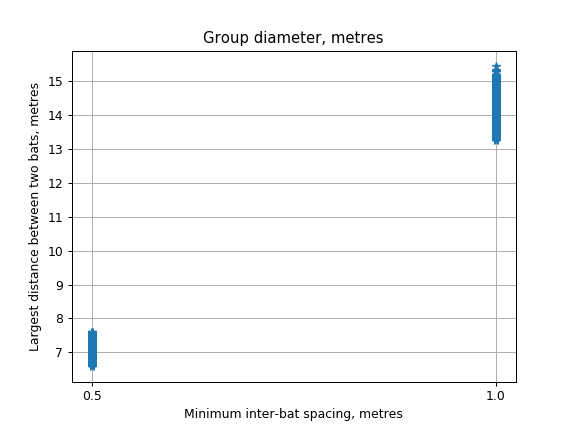

In [20]:
plt.figure()
plt.plot(simulation_data['min_spacing'], 
         simulation_data['group_diameter'], '*')
plt.xticks([0.5,1.0], [0.5,1.0]);plt.title('Group diameter, metres')
plt.ylabel('Largest distance between two bats, metres');plt.xlabel('Minimum inter-bat spacing, metres')
plt.grid();plt.yticks(np.arange(7,16),np.arange(7,16));

## What is the *effective* inter-neighbour distance ? 

### In the simulations bats were randomly placed in 2D Poisson disc placement of individuals [(Bridson)](https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf). The Poisson disc sampling method is a fast way to place many points that are randomly distributed while still maintaining a minimum inter-neighbour distance. This method is superior to a purely random placement of points as this results in very sparse or very dense areas. 

### Since the Poisson disc sampling method is random and only defines a *minimum* neighbour distance, I want to characterise the effective neighbour distance that was obtained. 

In [21]:
by_minspacing = simulation_data.groupby('min_spacing')

In [22]:
nearest_nbr_dist = {}
for spacing, df in by_minspacing:
    nearest_nbr_distances = df['nearest_neighbour_distance'].reset_index(drop=True)
    nearest_nbr_dist[spacing] = np.concatenate(nearest_nbr_distances)

In [23]:
nearest_nbr_dist

{0.5: array([0.54019403, 0.72554779, 0.80257895, ..., 0.51098873, 0.5572628 ,
        0.57889491]),
 1.0: array([1.01829291, 1.08773359, 1.34029416, ..., 1.05372665, 1.10920916,
        1.19157622])}

In [24]:
nearest_nbr_dists_for_plot = [nearest_nbr_dist[0.5], nearest_nbr_dist[1.0]]

<IPython.core.display.Javascript object>


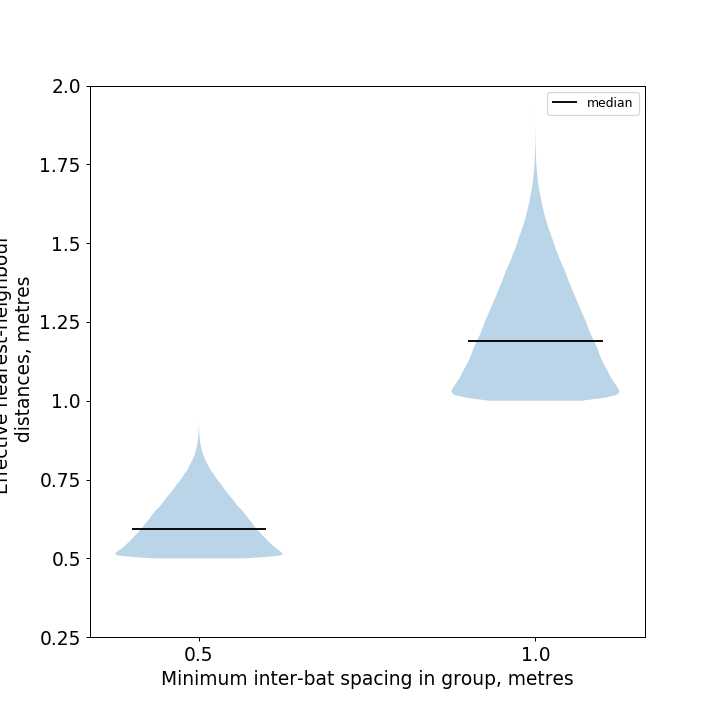

In [25]:
plt.figure(figsize=(8,8))
plt.violinplot(nearest_nbr_dists_for_plot, 
                           showextrema=False)
plt.xticks([1,2],[0.5,1.0],fontsize=15)
medians = map(np.median,nearest_nbr_dists_for_plot)
plt.hlines(medians, [0.8,1.8],[1.2,2.2], label='median')
plt.legend(fontsize=10)
plt.xlabel('Minimum inter-bat spacing in group, metres', fontsize=15)
plt.ylabel('Effective nearest-neighbour \n distances, metres', fontsize=15)
plt.yticks(np.arange(0.25,2.25,0.25), np.arange(0.25,2.25,0.25),fontsize=15);


### The effective nearest-neighbour distances, as measured from the three nearest neighbours of the focal bat is:


In [26]:
# for 0.5 m minimum spacing:
neighbour_spacing_pctile_50cm = np.percentile(nearest_nbr_dist[0.5], [5,50,95])
neighbour_spacing_pctile_50cm/0.5

array([1.01529721, 1.18835605, 1.53417138])

In [27]:
# the realised inter-neighbour distances by the ideal (and unachievable) 0.5 m distance
neighbour_spacing_pctile_50cm/0.5

array([1.01529721, 1.18835605, 1.53417138])

In [28]:
# for 1.0 m minimum spacing:
neighbour_spacing_pctile_100cm = np.percentile(nearest_nbr_dist[1.0], [5,50,95])
neighbour_spacing_pctile_100cm

array([1.01491067, 1.18829525, 1.53336743])

In [29]:
# the realised inter-neighbour distances by the ideal (and unachievable) 1.0 m distance

neighbour_spacing_pctile_100cm/1.0

array([1.01491067, 1.18829525, 1.53336743])

### We thus see that overall the nearest neighbour distances were within 1 - 1.5 X the minimum spacing distance. 

In [30]:
# check how many of eac`h parameter set was run:
param_sets, counts = np.unique(simulation_data['paramset_id'], return_counts=True) 

In [31]:
# Check if the number of obtained parameter sets matches 1200 - the expected number
len(param_sets)

1200

In [32]:
# check what the number of runs per parameter set we have :
np.unique(counts)

array([198, 199, 200, 384, 400])

#### Even after removing some simulation results that didn't save properly - we see that every parameter set has at least 198 simulation runs, and some parameter sets have more because they have been repeated or run previously. 

#### Are all of the parameter sets present in this dataset ? 
I expect there to be 1200 parameter sets.

In [33]:
simulation_data.head()

,echo_directions,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing
0,"0 -42.821 Name: theta, dtype: float64","0 63.713861 Name: level, dtype: float64",14.031807,100,1,[1.0182929060174475],"[1.0182929060174475, 1.0877335856221504, 1.340...","[90, 0.001, 0, 1.0, 106, 0.05, False]",90*0.001*0*1.0*106*0.05*False,94912172,91ac8769-d47e-4c1c-b361-8139618f53d4,90,0.0010,0,1.0,106,0.050,False
1,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.435634,100,0,[],"[1.0493998749894025, 1.06492414616569, 1.10910...","[10, 0.0025, -2, 1.0, 100, 0.05, True]",10*0.0025*-2*1.0*100*0.05*True,1068941441,4451633f-136b-47b7-b621-e8230fa7e785,10,0.0025,-2,1.0,100,0.050,True
2,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.301650,100,0,[],"[1.0060260860596875, 1.1223791237524812, 1.162...","[10, 0.0025, 0, 1.0, 120, 0.025, True]",10*0.0025*0*1.0*120*0.025*True,1002741347,27da2d2e-b54f-4330-91fd-3efccc25fbc9,10,0.0025,0,1.0,120,0.025,True
3,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.155366,100,0,[],"[1.0396475291117138, 1.3115191899611098, 1.456...","[90, 0.001, 0, 1.0, 106, 0.025, True]",90*0.001*0*1.0*106*0.025*True,339406604,3b2e5f9f-a0f8-4b35-8628-23f31adff634,90,0.0010,0,1.0,106,0.025,True
4,0 -112.3928 2 -5.9512 3 -63.4646 4 ...,0 51.091495 2 55.557987 3 50.246829 4...,13.861602,100,5,"[1.1352314065203282, 1.2276065717765738, 1.349...","[1.1352314065203282, 1.1998501080143635, 1.227...","[10, 0.001, -1, 1.0, 100, 0.3, False]",10*0.001*-1*1.0*100*0.3*False,376920471,a6f9c870-001a-454f-b3fa-d3db5848da98,10,0.0010,-1,1.0,100,0.300,False


In [34]:
call_durations = [0.001, 0.0025]
source_levels = [94, 100, 106, 112, 120]
neighbour_spacing = [0.5, 1.0]
implement_shadowing = [True, False]
ipi = [0.025, 0.05, 0.1, 0.2, 0.3]
heading_variation = [10, 90]
atm_abs = [0,-1,-2]

expected_parameter_sets = []
for heading in heading_variation:
    for calldurn in call_durations:
        for atmos_abs in atm_abs:
            for minspacing in neighbour_spacing:
                for level in source_levels:
                    for interpulse in ipi:
                        for shadowing in implement_shadowing:
                            parameset = [heading, calldurn, atmos_abs, minspacing,
                                        level, interpulse, shadowing]
                            paramset_id = join_all_parameters(parameset)
                            expected_parameter_sets.append(paramset_id)


In [35]:
expected_parameter_sets = set(expected_parameter_sets)

In [36]:
obtained_parameter_sets = set(np.unique(simulation_data['paramset_id']))

In [37]:
len(expected_parameter_sets.intersection(obtained_parameter_sets))

1200

In [38]:
unseen_parameter_sets = list(expected_parameter_sets - obtained_parameter_sets)
unseen_parameter_sets

[]

In [39]:
len(list(expected_parameter_sets - obtained_parameter_sets))

0

#### Thus, we see that all the *expected* parameter sets are now present in the final output data. 

<IPython.core.display.Javascript object>


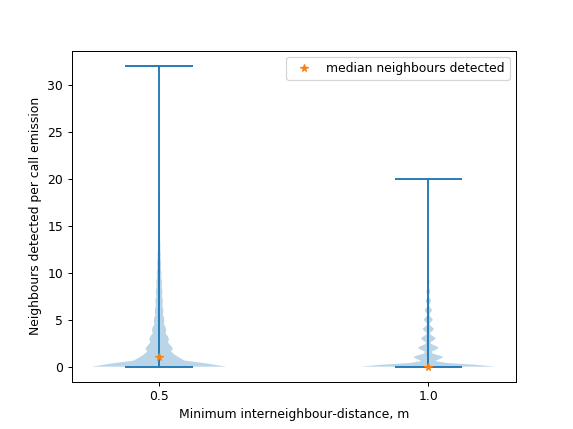

In [40]:
by_spacing = simulation_data.groupby('min_spacing')
neighbours_by_spacing = [ np.array(df['nbrs_detected']) for value, df in by_spacing]
plt.figure()
plt.violinplot(neighbours_by_spacing)
plt.plot([1,2],map(np.median, neighbours_by_spacing), '*', label='median neighbours detected')

plt.xticks([1,2],[0.5,1.0]); plt.xlabel('Minimum interneighbour-distance, m');
plt.ylabel('Neighbours detected per call emission')
plt.legend()

<IPython.core.display.Javascript object>


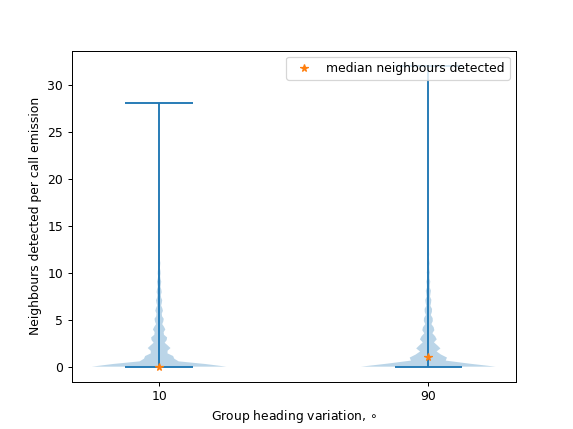

In [41]:
by_heading = simulation_data.groupby('heading_variation')
neighbours_by_heading = [ np.array(df['nbrs_detected']) for value, df in by_heading]
median_neighbours_by_heading = map(np.median, neighbours_by_heading)
plt.figure()
plt.violinplot(neighbours_by_heading)
plt.plot([1,2],median_neighbours_by_heading, '*', label='median neighbours detected')
plt.xticks([1,2],[10,90]); plt.xlabel('Group heading variation, $\circ$');
plt.ylabel('Neighbours detected per call emission')
plt.legend()

<IPython.core.display.Javascript object>


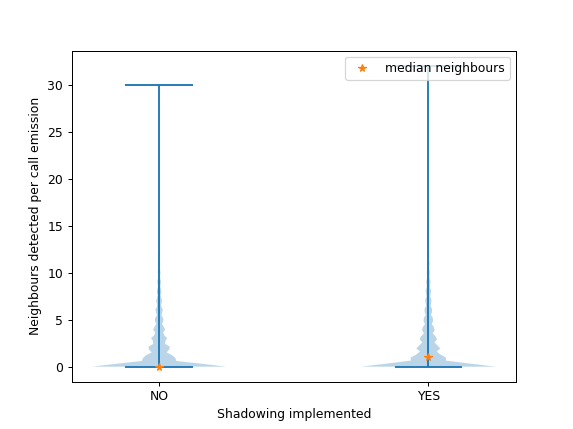

In [42]:
by_shadowing = simulation_data.groupby('implement_shadowing')
neighbours_by_shadowing = [ np.array(df['nbrs_detected']) for value, df in by_shadowing]
plt.figure()
plt.violinplot(neighbours_by_shadowing)
plt.plot([1,2], map(np.median, neighbours_by_shadowing), '*',
                     label='median neighbours')
plt.xticks([1,2],['NO', 'YES']); plt.xlabel('Shadowing implemented');
plt.ylabel('Neighbours detected per call emission')
plt.legend()

<IPython.core.display.Javascript object>


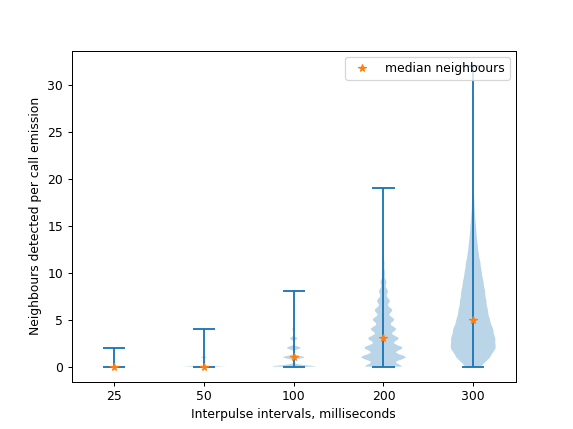

In [43]:
by_ipi = simulation_data.groupby('interpulse_interval')
neighbours_by_ipi = [ np.array(df['nbrs_detected']) for value, df in by_ipi]
plt.figure()
plt.violinplot(neighbours_by_ipi)
plt.plot(range(1,6), map(np.median, neighbours_by_ipi), '*',
                     label='median neighbours')
plt.xticks([1,2,3,4,5],[25, 50, 100, 200, 300]); plt.xlabel('Interpulse intervals, milliseconds');
plt.ylabel('Neighbours detected per call emission')
plt.legend()

<IPython.core.display.Javascript object>


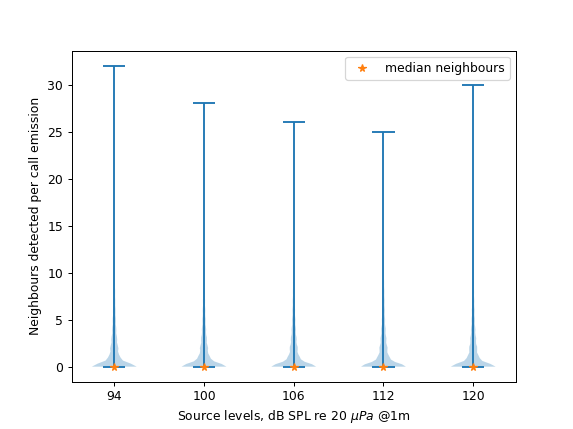

In [44]:
by_sl = simulation_data.groupby('source_level')
neighbours_by_sl = [ np.array(df['nbrs_detected']) for value, df in by_sl]
plt.figure()
plt.violinplot(neighbours_by_sl)
plt.plot(range(1,6), map(np.median, neighbours_by_sl), '*',
                     label='median neighbours')
plt.xticks([1,2,3,4,5],[94, 100, 106, 112, 120]); plt.xlabel('Source levels, dB SPL re 20 $\mu Pa$ @1m');
plt.ylabel('Neighbours detected per call emission')
plt.legend()

<IPython.core.display.Javascript object>


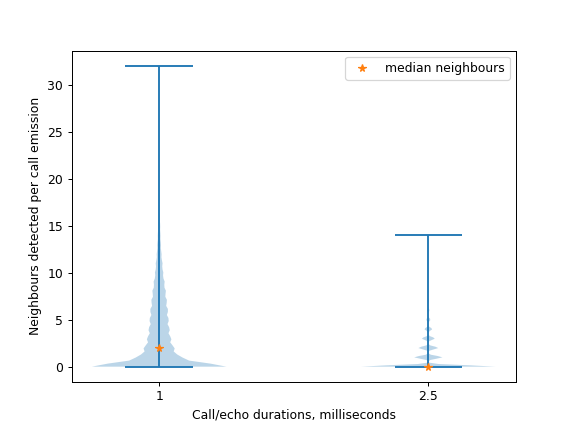

In [45]:
by_duration = simulation_data.groupby('echocall_duration')
neighbours_by_duration = [ np.array(df['nbrs_detected']) for value, df in by_duration]
plt.figure()
plt.violinplot(neighbours_by_duration)
plt.plot([1,2], map(np.median, neighbours_by_duration), '*',
                     label='median neighbours')
plt.xticks([1,2],[1, 2.5]); plt.xlabel('Call/echo durations, milliseconds');
plt.ylabel('Neighbours detected per call emission')
plt.legend()

<IPython.core.display.Javascript object>


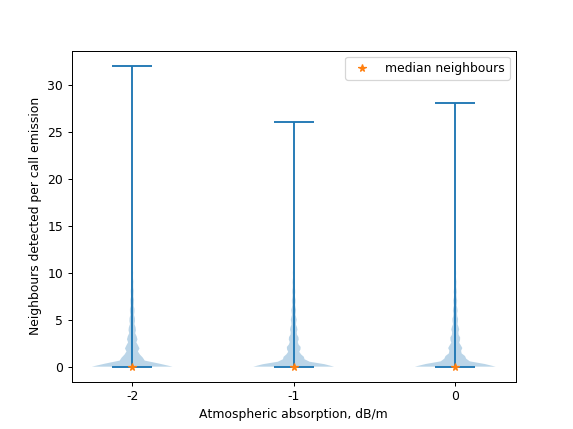

In [46]:
by_attenuation = simulation_data.groupby('atmospheric_attenuation')
neighbours_by_atmabs = [ np.array(df['nbrs_detected']) for value, df in by_attenuation]
plt.figure()
plt.violinplot(neighbours_by_atmabs)
plt.plot(range(1,4), map(np.median, neighbours_by_atmabs), '*',
                     label='median neighbours')
plt.xticks([1,2,3],[-2, -1, 0]); plt.xlabel('Atmospheric absorption, dB/m');
plt.ylabel('Neighbours detected per call emission')
plt.legend()

# Running regression analyses on the simulation outputs :

### Having done some visualisations - let's now do some regressions to understand how all of the variables contribute overall to the number of echoes a focal bat can actually detect:

In [47]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [48]:
simulation_data.head()

,echo_directions,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing
0,"0 -42.821 Name: theta, dtype: float64","0 63.713861 Name: level, dtype: float64",14.031807,100,1,[1.0182929060174475],"[1.0182929060174475, 1.0877335856221504, 1.340...","[90, 0.001, 0, 1.0, 106, 0.05, False]",90*0.001*0*1.0*106*0.05*False,94912172,91ac8769-d47e-4c1c-b361-8139618f53d4,90,0.0010,0,1.0,106,0.050,False
1,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.435634,100,0,[],"[1.0493998749894025, 1.06492414616569, 1.10910...","[10, 0.0025, -2, 1.0, 100, 0.05, True]",10*0.0025*-2*1.0*100*0.05*True,1068941441,4451633f-136b-47b7-b621-e8230fa7e785,10,0.0025,-2,1.0,100,0.050,True
2,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.301650,100,0,[],"[1.0060260860596875, 1.1223791237524812, 1.162...","[10, 0.0025, 0, 1.0, 120, 0.025, True]",10*0.0025*0*1.0*120*0.025*True,1002741347,27da2d2e-b54f-4330-91fd-3efccc25fbc9,10,0.0025,0,1.0,120,0.025,True
3,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.155366,100,0,[],"[1.0396475291117138, 1.3115191899611098, 1.456...","[90, 0.001, 0, 1.0, 106, 0.025, True]",90*0.001*0*1.0*106*0.025*True,339406604,3b2e5f9f-a0f8-4b35-8628-23f31adff634,90,0.0010,0,1.0,106,0.025,True
4,0 -112.3928 2 -5.9512 3 -63.4646 4 ...,0 51.091495 2 55.557987 3 50.246829 4...,13.861602,100,5,"[1.1352314065203282, 1.2276065717765738, 1.349...","[1.1352314065203282, 1.1998501080143635, 1.227...","[10, 0.001, -1, 1.0, 100, 0.3, False]",10*0.001*-1*1.0*100*0.3*False,376920471,a6f9c870-001a-454f-b3fa-d3db5848da98,10,0.0010,-1,1.0,100,0.300,False


In [49]:
# make most of the columns categorical because I've done such sparse sampling
regression_rundata = simulation_data.copy()
#for column in keyword_arguments['variables_to_extract'] :
#    regression_rundata[column] = regression_rundata[column].astype('category')

In [50]:
from pandas.api.types import CategoricalDtype

In [51]:
# making the variables categorical and choosing the reference class according 
# to those done in the group size simulations
ipi_type = CategoricalDtype(categories=[0.1,0.05,0.025,0.200,0.300],
                             ordered=True)
echocall_type = CategoricalDtype(categories=[0.0025, 0.001],
                             ordered=True)
heading_type = CategoricalDtype(categories=[10,90],
                             ordered=True)
aa_type = CategoricalDtype(categories=[-1,0,-2],
                          ordered=True)
min_spacing_type = CategoricalDtype(categories=[0.5, 1.0],
                          ordered=True)
sl_type = CategoricalDtype(categories=[100,94,106,112,120],
                          ordered=True)
shadowing_type = CategoricalDtype(categories=[True, False],
                          ordered=True)

# the reference class + actual class names of each variable to be set
all_categorical_types = [heading_type, echocall_type, aa_type, min_spacing_type, 
                         sl_type, ipi_type, shadowing_type]

for column, categorical_type in zip(keyword_arguments['variables_to_extract'], all_categorical_types):
    regression_rundata[column] = regression_rundata[column].astype(categorical_type)

In [52]:
formula = 'nbrs_detected~heading_variation+atmospheric_attenuation \
            +implement_shadowing+interpulse_interval+min_spacing+source_level+echocall_duration\
            +source_level+atmospheric_attenuation'


## Which parameters predict the probability of detecting at least 1 neighbour ?
### I now reduce the whole problem to whether a neighbour was detected or not! Every simulation give 0 or $\ge$ 0 number of neighbours detected. This will then reduce it to a binomial distribution, where the two states are 'no neighbours detected' and 'at least one neighbour detected'.

In [53]:
at_least_one = regression_rundata['nbrs_detected'] > 0
regression_rundata['geq_oneneighbour'] = np.zeros(at_least_one.size)
regression_rundata.loc[at_least_one,'geq_oneneighbour'] = 1

In [54]:
detection = regression_rundata['geq_oneneighbour']

In [55]:
# only presenting the final and reduced model 
logit_formula = 'geq_oneneighbour~ heading_variation+ \
        implement_shadowing+interpulse_interval+\
        min_spacing+echocall_duration+source_level+atmospheric_attenuation'

In [56]:
logit_model = smf.logit(logit_formula, data=regression_rundata)
logit_fit = logit_model.fit( maxiter=200)

Optimization terminated successfully.
         Current function value: 0.238334
         Iterations 10


In [57]:
regression_rundata.head()

,echo_directions,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing,geq_oneneighbour
0,"0 -42.821 Name: theta, dtype: float64","0 63.713861 Name: level, dtype: float64",14.031807,100,1,[1.0182929060174475],"[1.0182929060174475, 1.0877335856221504, 1.340...","[90, 0.001, 0, 1.0, 106, 0.05, False]",90*0.001*0*1.0*106*0.05*False,94912172,91ac8769-d47e-4c1c-b361-8139618f53d4,90,0.0010,0,1.0,106,0.050,False,1.0
1,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.435634,100,0,[],"[1.0493998749894025, 1.06492414616569, 1.10910...","[10, 0.0025, -2, 1.0, 100, 0.05, True]",10*0.0025*-2*1.0*100*0.05*True,1068941441,4451633f-136b-47b7-b621-e8230fa7e785,10,0.0025,-2,1.0,100,0.050,True,0.0
2,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.301650,100,0,[],"[1.0060260860596875, 1.1223791237524812, 1.162...","[10, 0.0025, 0, 1.0, 120, 0.025, True]",10*0.0025*0*1.0*120*0.025*True,1002741347,27da2d2e-b54f-4330-91fd-3efccc25fbc9,10,0.0025,0,1.0,120,0.025,True,0.0
3,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.155366,100,0,[],"[1.0396475291117138, 1.3115191899611098, 1.456...","[90, 0.001, 0, 1.0, 106, 0.025, True]",90*0.001*0*1.0*106*0.025*True,339406604,3b2e5f9f-a0f8-4b35-8628-23f31adff634,90,0.0010,0,1.0,106,0.025,True,0.0
4,0 -112.3928 2 -5.9512 3 -63.4646 4 ...,0 51.091495 2 55.557987 3 50.246829 4...,13.861602,100,5,"[1.1352314065203282, 1.2276065717765738, 1.349...","[1.1352314065203282, 1.1998501080143635, 1.227...","[10, 0.001, -1, 1.0, 100, 0.3, False]",10*0.001*-1*1.0*100*0.3*False,376920471,a6f9c870-001a-454f-b3fa-d3db5848da98,10,0.0010,-1,1.0,100,0.300,False,1.0


In [58]:
logit_predict = logit_fit.predict()

In [59]:
logit_resid = detection - logit_predict

### Let's build an ROC curve to figure out which thresholds give us the best predictions - and then use it to decide how well the logistic regression model predicts the $P(\geq1 neighbour)$  being detected.

In [60]:
from sklearn import metrics


In [61]:
fpr, tpr, thresholds = metrics.roc_curve(detection, logit_predict)
roc_data = pd.DataFrame(data={'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds})

<IPython.core.display.Javascript object>


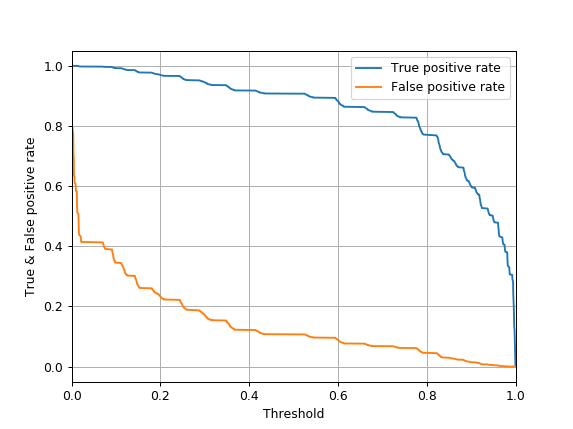

In [62]:
plt.figure()
plt.plot(thresholds, tpr, label='True positive rate')
plt.plot(thresholds, fpr, label='False positive rate')
plt.xlim(0,1)
plt.xlabel('Threshold');plt.ylabel('True & False positive rate')
plt.legend();plt.grid()

### Choosing a reasonable threshold to get the confusion matrix from the logistic regression results:
 The ROC curve above shows us how the false and true positive rates vary as we alter the threshold at which we consider $\geq1$ neighbour detected. The model should have a low false positive rate to be useful, and so I will choose accept a 5% false positive rate. Within the thresholds that satsify this criteria, I will then choose the threshold with the highest true positive rate. 

In [63]:
acceptable_fpr = 0.05
rows_w_acceptable_fpr = roc_data[roc_data['fpr']<=acceptable_fpr].reset_index(drop=True)
highest_tpr_row = rows_w_acceptable_fpr['tpr'].argmax()
best_threshold = rows_w_acceptable_fpr.loc[highest_tpr_row,:]['thresholds']

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  app.launch_new_instance()


In [64]:
best_threshold

0.7861980084949216

<IPython.core.display.Javascript object>


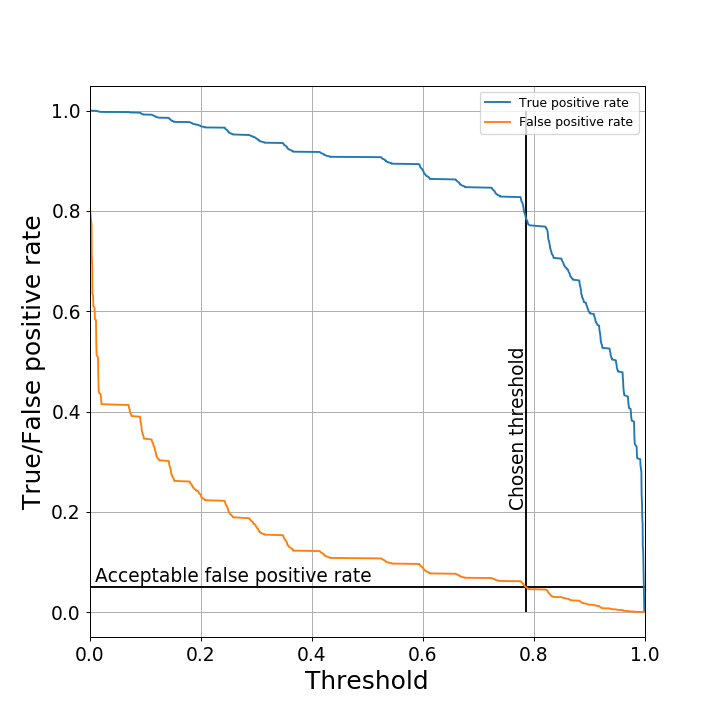

Text(0.01,0.06,'Acceptable false positive rate')

In [65]:
plt.figure(figsize=(8,8))
plt.plot(thresholds, tpr, label='True positive rate')
plt.plot(thresholds, fpr, label='False positive rate')
plt.xlim(0,1)
plt.xticks(fontsize=15);plt.yticks(fontsize=15)
plt.xlabel('Threshold', fontsize=20);plt.ylabel('True/False positive rate',fontsize=20)
plt.legend();plt.grid()
plt.vlines(best_threshold,0,1);
plt.hlines(acceptable_fpr, 0, 1)
plt.text(best_threshold-0.03, 0.5,'Chosen threshold', rotation=90, fontsize=15)
plt.text(0.01,acceptable_fpr+0.01,'Acceptable false positive rate',fontsize=15)

In [66]:
from sklearn.preprocessing import Binarizer 

In [67]:
binarise_probs = Binarizer(best_threshold)
predicted_binary = binarise_probs.fit_transform(logit_predict.reshape(-1,1))

In [68]:
logit_confusion_matrix = metrics.confusion_matrix(detection, predicted_binary)
true_positive, false_positive, true_negative, false_negative = metrics.confusion_matrix(detection, 
                                                                                        predicted_binary).ravel()

In [69]:
true_positive, false_positive, true_negative, false_negative

(116038, 6024, 25546, 92958)

In [70]:
logit_confusion_matrix

array([[116038,   6024],
       [ 25546,  92958]])

In [71]:
true_positive, false_positive, true_negative, false_negative

(116038, 6024, 25546, 92958)

In [72]:
def calc_rate_per_column(X):
    X_float = np.float64(X)
    X_rate = X_float/np.sum(X_float)
    return(X_rate)

In [73]:
rate_logit = np.apply_along_axis(calc_rate_per_column, 0, logit_confusion_matrix)

In [74]:
np.around(rate_logit,2)

array([[0.82, 0.06],
       [0.18, 0.94]])

In [75]:
# rows are the predicted values - columns are the observed values
pd.DataFrame(np.around(rate_logit,2), columns=['1','0'], index=['1','0'])

,1,0
1,0.82,0.06
0,0.18,0.94


### The logistic regression predicting whether $\geq1$ neighbour is heard seems to be a much better model. It predicts the observed data with a 82% true negative and 94% true positive rate. I am currently satisfied with this mdoel - and now let us see which parameters affect the probability of hearing at least one neighbour. 

In [76]:
np.unique(regression_rundata['interpulse_interval'],return_counts=True)

(array([0.025, 0.05 , 0.1  , 0.2  , 0.3  ]),
 array([47993, 47993, 47996, 48584, 48000]))

In [77]:
regression_table = logit_fit.summary2().tables[1]
regression_table

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-1.113434,0.027488,-40.506341,0.000000e+00,-1.167309,-1.059559
heading_variation[T.90],0.277998,0.015149,18.350365,3.279027e-75,0.248306,0.307690
implement_shadowing[T.False],-0.282284,0.015150,-18.632027,1.767029e-77,-0.311978,-0.252590
interpulse_interval[T.0.05],-3.038114,0.022648,-134.143095,0.000000e+00,-3.082504,-2.993725
interpulse_interval[T.0.025],-6.843472,0.073177,-93.519569,0.000000e+00,-6.986896,-6.700048
interpulse_interval[T.0.2],2.680945,0.021541,124.458483,0.000000e+00,2.638726,2.723165
interpulse_interval[T.0.3],4.313286,0.029443,146.494755,0.000000e+00,4.255578,4.370993
min_spacing[T.1.0],-1.167400,0.016030,-72.826236,0.000000e+00,-1.198818,-1.135982
echocall_duration[T.0.001],3.545456,0.022322,158.834188,0.000000e+00,3.501706,3.589205
source_level[T.94],-0.013584,0.023914,-0.568033,5.700127e-01,-0.060453,0.033286


### To interpret the model we need to first convert the coefficients from log(odds ratio) to odds ratio. See [here](https://rpubs.com/OmaymaS/182726) for a nice explanation of interpreting logistic regresion outcomes.

In [78]:
# Convert log(odds ratio) to odds ratio :
pd.DataFrame(data = {'oddsratio':np.exp(logit_fit.params),'pvalue': np.around(logit_fit.pvalues,2)})

,oddsratio,pvalue
Intercept,0.328429,0.00
heading_variation[T.90],1.320484,0.00
implement_shadowing[T.False],0.754059,0.00
interpulse_interval[T.0.05],0.047925,0.00
interpulse_interval[T.0.025],0.001066,0.00
interpulse_interval[T.0.2],14.598885,0.00
interpulse_interval[T.0.3],74.685475,0.00
min_spacing[T.1.0],0.311175,0.00
echocall_duration[T.0.001],34.655467,0.00
source_level[T.94],0.986508,0.57


## Can the simulation parameters also be treated as continuous variables for a logistic regression?

### I initially made all simulation parameters into categorical variables as only a few values had been run per variable. Could I turn them into continuous variables and still retain the same trend? Treating the parameters as continuous variables will allow me to calculate a standardised coefficient, and thus compare the strength of each parameter in neighbour detection. 

In [79]:
regression_data_continuous = simulation_data.copy()

In [80]:
at_least_one = regression_data_continuous['nbrs_detected'] > 0
regression_data_continuous['geq_oneneighbour'] = np.zeros(at_least_one.size)
regression_data_continuous.loc[at_least_one,'geq_oneneighbour'] = 1

In [81]:
# re-scale echocall_duration to milliseconds from seconds to get a sensible coefficient!
regression_data_continuous['echocall_duration'] *= 10**3

In [82]:
regression_data_continuous.head()

,echo_directions,echo_levels,group_diameter,group_size,nbrs_detected,nbrs_detected_distance,nearest_neighbour_distance,parameters_joint,paramset_id,seed,uuid,heading_variation,echocall_duration,atmospheric_attenuation,min_spacing,source_level,interpulse_interval,implement_shadowing,geq_oneneighbour
0,"0 -42.821 Name: theta, dtype: float64","0 63.713861 Name: level, dtype: float64",14.031807,100,1,[1.0182929060174475],"[1.0182929060174475, 1.0877335856221504, 1.340...","[90, 0.001, 0, 1.0, 106, 0.05, False]",90*0.001*0*1.0*106*0.05*False,94912172,91ac8769-d47e-4c1c-b361-8139618f53d4,90,1.0,0,1.0,106,0.050,False,1.0
1,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.435634,100,0,[],"[1.0493998749894025, 1.06492414616569, 1.10910...","[10, 0.0025, -2, 1.0, 100, 0.05, True]",10*0.0025*-2*1.0*100*0.05*True,1068941441,4451633f-136b-47b7-b621-e8230fa7e785,10,2.5,-2,1.0,100,0.050,True,0.0
2,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.301650,100,0,[],"[1.0060260860596875, 1.1223791237524812, 1.162...","[10, 0.0025, 0, 1.0, 120, 0.025, True]",10*0.0025*0*1.0*120*0.025*True,1002741347,27da2d2e-b54f-4330-91fd-3efccc25fbc9,10,2.5,0,1.0,120,0.025,True,0.0
3,"Series([], Name: theta, dtype: float64)","Series([], Name: level, dtype: float64)",14.155366,100,0,[],"[1.0396475291117138, 1.3115191899611098, 1.456...","[90, 0.001, 0, 1.0, 106, 0.025, True]",90*0.001*0*1.0*106*0.025*True,339406604,3b2e5f9f-a0f8-4b35-8628-23f31adff634,90,1.0,0,1.0,106,0.025,True,0.0
4,0 -112.3928 2 -5.9512 3 -63.4646 4 ...,0 51.091495 2 55.557987 3 50.246829 4...,13.861602,100,5,"[1.1352314065203282, 1.2276065717765738, 1.349...","[1.1352314065203282, 1.1998501080143635, 1.227...","[10, 0.001, -1, 1.0, 100, 0.3, False]",10*0.001*-1*1.0*100*0.3*False,376920471,a6f9c870-001a-454f-b3fa-d3db5848da98,10,1.0,-1,1.0,100,0.300,False,1.0


In [83]:
# make all parameters with only two values into categorical as their true effect may be hard to estimate :
regression_data_continuous['echocall_duration'] = regression_data_continuous['echocall_duration'].astype('category')
regression_data_continuous['heading_variation'] = regression_data_continuous['heading_variation'].astype('category')

In [84]:
logit_model_continuous = smf.logit(logit_formula, data=regression_data_continuous)
logit_fit_continuous = logit_model_continuous.fit( maxiter=200)

Optimization terminated successfully.
         Current function value: 0.273174
         Iterations 8


In [85]:
logit_continuous_summary = logit_fit_continuous.summary()

In [86]:
s2 = logit_fit_continuous.summary2()

In [87]:
regression_outputs = s2.tables[1]

In [88]:
logit_continuous_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       geq_oneneighbour   No. Observations:               240566
Model:                          Logit   Df Residuals:                   240558
Method:                           MLE   Df Model:                            7
Date:                Fri, 18 Oct 2019   Pseudo R-squ.:                  0.6058
Time:                        07:49:20   Log-Likelihood:                -65716.
converged:                       True   LL-Null:                   -1.6672e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.4222      0.086    -16.542      0.000      -1.591      -1.254
heading_variation[T.90]         0.2374      0.014     16.969      0.000       0.210       0.265
implement_shadowing[T.True]     0.2413      0.014     17.246      0.000       0.214       0.269
echocall_duration[T.2.5]       -3.2007      0.021   -155.992      0.000      -3.241      -3.160
interpulse_interval            34.4122      0.149    230.188      0.000      34.119      34.705
min_spacing                    -1.9728      0.029    -68.325      0.000      -2.029      -1.916
source_level                 2.763e-05      0.001      0.036      0.971      -0.001       0.002
atmospheric_attenuation         0.0171      0.009      2.001      0.045       0.000       0.034
===============================================================================================
"""

In [89]:
odds_ratio = np.exp(logit_fit_continuous.params)
odds_ratio

Intercept                      2.411759e-01
heading_variation[T.90]        1.267970e+00
implement_shadowing[T.True]    1.272909e+00
echocall_duration[T.2.5]       4.073391e-02
interpulse_interval            8.810926e+14
min_spacing                    1.390696e-01
source_level                   1.000028e+00
atmospheric_attenuation        1.017244e+00
dtype: float64

In [90]:
logit_continuous_predict = logit_fit_continuous.predict()

In [91]:
fpr_continuous, tpr_continuous, thresholds_continuous = metrics.roc_curve(detection, 
                                                                          logit_continuous_predict)
roc_data_continuous = pd.DataFrame(data={'tpr':tpr_continuous, 'fpr':fpr_continuous, 
                                         'thresholds':thresholds_continuous})

In [92]:
rows_w_acceptable_fpr_continuous = roc_data_continuous[roc_data_continuous['fpr']<=acceptable_fpr].reset_index(drop=True)
highest_tpr_row_continuous = rows_w_acceptable_fpr_continuous['tpr'].argmax()
best_threshold_continuous = rows_w_acceptable_fpr_continuous.loc[highest_tpr_row_continuous,:]['thresholds']

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


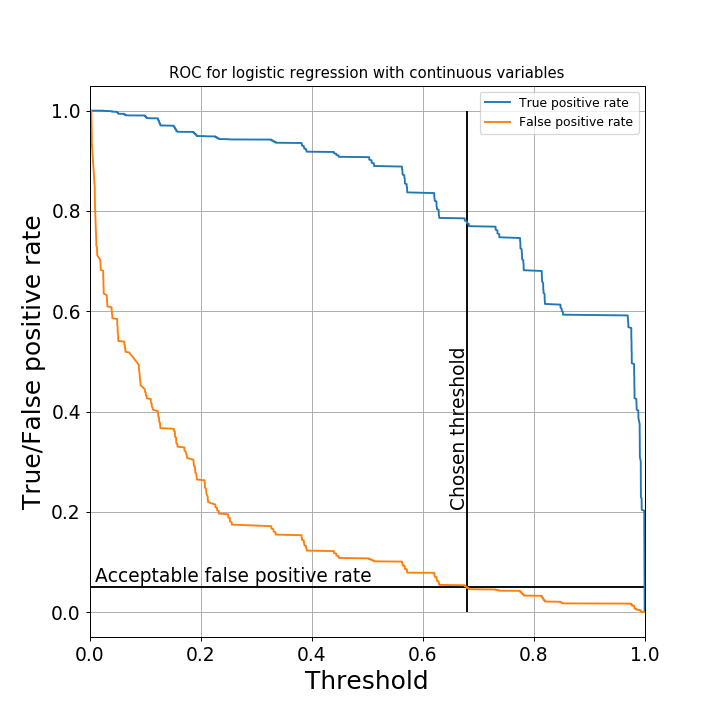

Text(0.01,0.06,'Acceptable false positive rate')

In [93]:
plt.figure(figsize=(8,8))
plt.title('ROC for logistic regression with continuous variables')
plt.plot(thresholds_continuous, tpr_continuous, label='True positive rate')
plt.plot(thresholds_continuous, fpr_continuous, label='False positive rate')
plt.xlim(0,1)
plt.xticks(fontsize=15);plt.yticks(fontsize=15)
plt.xlabel('Threshold', fontsize=20);plt.ylabel('True/False positive rate',fontsize=20)
plt.legend();plt.grid()
plt.vlines(best_threshold_continuous,0,1);
plt.hlines(acceptable_fpr, 0, 1)
plt.text(best_threshold_continuous-0.03, 0.5,'Chosen threshold', rotation=90, fontsize=15)
plt.text(0.01,acceptable_fpr+0.01,'Acceptable false positive rate',fontsize=15)

In [94]:
binarise_probs_continuous = Binarizer(best_threshold_continuous)
predicted_binary_continuous = binarise_probs_continuous.fit_transform(logit_continuous_predict.reshape(-1,1))
logit_continuous_confusion_matrix = metrics.confusion_matrix(detection, predicted_binary_continuous)

rate_logit_continuous = np.apply_along_axis(calc_rate_per_column, 0, logit_continuous_confusion_matrix)

pd.DataFrame(np.around(rate_logit_continuous,2), columns=['1','0'], index=['1','0'])


,1,0
1,0.81,0.06
0,0.19,0.94


## It seems like when interpulse interval  is treated as a continuous variable it shows quasi/complete separation?

In [95]:
def calculate_probability_of_detection(dataframe):
    detection_probability = np.mean(dataframe['geq_oneneighbour'])
    return(detection_probability)

data_by_ipi = regression_data_continuous.groupby('interpulse_interval')
ipi_and_detectionprob = []
for ipi, dataframe in data_by_ipi:
    prob_detection = calculate_probability_of_detection(dataframe)
    ipi_and_detectionprob.append([ipi, prob_detection])

In [96]:
ipi, detectionprob = np.split(np.concatenate(ipi_and_detectionprob).reshape(-1,2), 2,1)

<IPython.core.display.Javascript object>


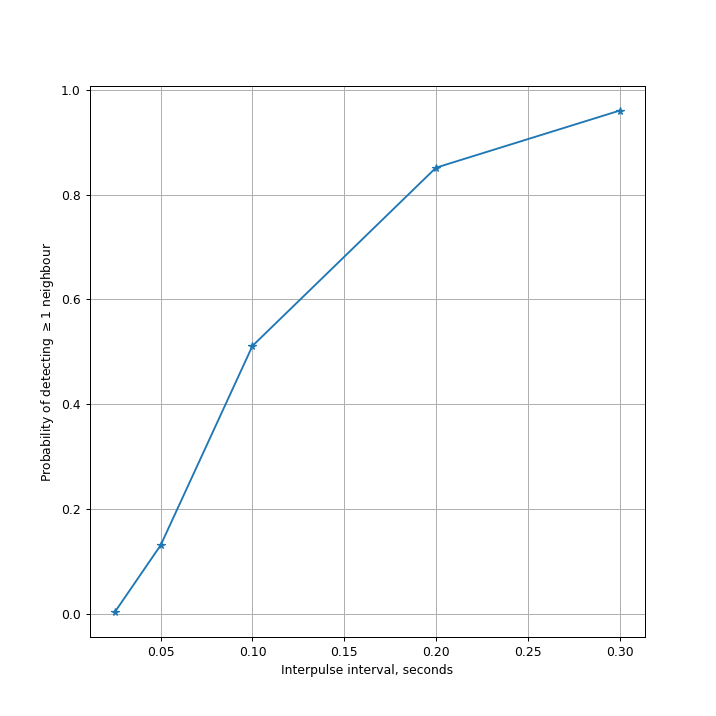

In [97]:
plt.figure(figsize=(8,8))
plt.plot(ipi, detectionprob, '*-')

plt.xlabel('Interpulse interval, seconds')
plt.ylabel('Probability of detecting $\geq$1 neighbour')
plt.grid()

### The probability of detection at interpulse $\leq$50ms interval is rather low - this is causing the separation and thus the very large interpulse interval coefficients. 

## Perhaps its better to use the fully categorical logistic regression!
### The odds ratio estimate of interpulse interval is *very* large. The logistic regression with some parameters treated as continuous shows perfect separation [1,2].  This doesn't allow me to interpret the model - even though it does predict the data as well as the fully categorical model.  Moreover, as suggested in [3], one of the options to overcome separation is to convert the continuous variable into a categorical variable. 


### $References:$
1) Heinze, G., & Schemper, M. (2002). A solution to the problem of separation in logistic regression. Statistics in medicine, 21(16), 2409-2419.
2) [Minitab page explanation on separation](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/regression-models/what-are-complete-separation-and-quasi-complete-separation/) accessed 14/10/2019
3) Mansournia, M. A., Geroldinger, A., Greenland, S., & Heinze, G. (2017). Separation in logistic regression: causes, consequences, and control. American journal of epidemiology, 187(4), 864-870.

### A note on the final and only model:
I have not attempted any kind of model selection/reduction as the intention of the regression analyses is to quantify the extent to which each variable contributes to neighbour detection. Moreover the simulations themselves are a result of *all* variables being altered intentionally - and so I chose to keep them final model (Bolker et 2009) even at the cost of less precise predictions. 

### Reference:
Bolker, B. M., Brooks, M. E., Clark, C. J., Geange, S. W., Poulsen, J. R., Stevens, M. H. H., & White, J. S. S. (2009). Generalized linear mixed models: a practical guide for ecology and evolution. Trends in ecology & evolution, 24(3), 127-135.

## Interpreting the model :
This section reports the results of the fully categorical logistic regression.  

### 1. Inter pulse intervals play a strong role : 
The interpulse interval (ipi) is duration of time between the end of one call and the start of the next call. The longer the interpulse interval, the longer a bat waits between two calls. In the simulations, every bat had the same interpulse interval - and we see that the longer the time bats wait between calls - the better they are able to detect their neighbours. The reference group here was $interpulse \ interval = 25 milliseconds$, and we see dramatic odds ratios as the interpulse interval is increased first to 50 and then 100 milliseconds. The odds ratio of detecting a neighbour increases 45 (at 50ms ipi) to 70,035 (300 ms ipi) times the reference of 25 ms ipi. 

### 2. Acoustic shadowing promotes neighbour detection : 
Here I refer to acoustic shadowing as the decrease in sound pressure level of a sound as it passes obstacles. In a group of bats, the neighbouring bats centred around a focal bat are the obstacles. The reference group ('implement_shadowing') is the set of simulations without acoustic shadowing implemented - where every bat is 'transparent' when sounds pass through them. The odds ratio increases 1.32 times by implementing acoustic shadowing. 

### 3. Heading variation in a group increases neighbour detection : 
This parameter describes the amount of variation in the direction that individuals are pointing their beams at. The reference group is $heading \ variation = 10 ^\circ$ and we see that a group with  $heading \ variation = 90 ^\circ$ has a 1.32 time increase in detecting $\geq1$ neighbour. This implies that a group engaging in behaviours where there is low alignment of bat scanning/flight directions could actually be advantageous. 


### 4. Bats flying closer to each other can detect each other better :
The minimum spacing between two adjacent bats was set to be either 0.5 or 1.0 meters. When bats were placed further from each other (1m minimum spacing) they detected each other better in the midst of the loud calls, than when they were further apart (0.5m minimum spacing). The reference group is 0.5m minimum spacing, and we see the odds ratio drops to 0.3 at 1.0m minimum spacing between bats. 

### 5. Shorter calls allow better detection of neighbours : 
Calls were set to be either 1ms or 2.5ms long. The reference was the neighbour detection at 1ms call duration. A longer call of 2.5 ms led to the odds ratio dropping to ~ 0.03 times the reference group. 

### 6. Call source levels do not affect neighbour detection : 
All bats in a group were simulated to emit calls at one of 94, 100, 106, 112 or 120 dB SPL re 20 $\mu$Pa at 1m. 
The regressions results show mixed and very small variations in odds ratio was between 0.99-1.03 times the reference group. 
The reference group was all bats emitting at 94 dB SPL re 20 $\mu$Pa at 1m. Since all bats were emitting at the same 
source level - there was no change in echo to masker levels and thus source levels do not contribute to much variation in the detection of neighbours. 

### 7. Atmospheric attenuation : 
The atmospheric attenuation varied between 0, -1 and -2 dB/m. The reference group was -2 dB/m. The odds ratio of neighbour detection for different atmospheric absorption rates  lies between 0.99-1.04. Variation in atmospheric attenuation is also not expected to change neighbour detection because there is no effective change in the echo-masker levels. The effect of atmospheric absorption is applicable to both echoes and maskers equally. 

## Visualising the odds ratios of each parameter value in comparison to the reference class

In [98]:
pd.DataFrame(data = {'oddsratio':np.exp(logit_fit.params),'pvalue': np.around(logit_fit.pvalues,2)})

,oddsratio,pvalue
Intercept,0.328429,0.00
heading_variation[T.90],1.320484,0.00
implement_shadowing[T.False],0.754059,0.00
interpulse_interval[T.0.05],0.047925,0.00
interpulse_interval[T.0.025],0.001066,0.00
interpulse_interval[T.0.2],14.598885,0.00
interpulse_interval[T.0.3],74.685475,0.00
min_spacing[T.1.0],0.311175,0.00
echocall_duration[T.0.001],34.655467,0.00
source_level[T.94],0.986508,0.57


In [99]:
regression_table

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-1.113434,0.027488,-40.506341,0.000000e+00,-1.167309,-1.059559
heading_variation[T.90],0.277998,0.015149,18.350365,3.279027e-75,0.248306,0.307690
implement_shadowing[T.False],-0.282284,0.015150,-18.632027,1.767029e-77,-0.311978,-0.252590
interpulse_interval[T.0.05],-3.038114,0.022648,-134.143095,0.000000e+00,-3.082504,-2.993725
interpulse_interval[T.0.025],-6.843472,0.073177,-93.519569,0.000000e+00,-6.986896,-6.700048
interpulse_interval[T.0.2],2.680945,0.021541,124.458483,0.000000e+00,2.638726,2.723165
interpulse_interval[T.0.3],4.313286,0.029443,146.494755,0.000000e+00,4.255578,4.370993
min_spacing[T.1.0],-1.167400,0.016030,-72.826236,0.000000e+00,-1.198818,-1.135982
echocall_duration[T.0.001],3.545456,0.022322,158.834188,0.000000e+00,3.501706,3.589205
source_level[T.94],-0.013584,0.023914,-0.568033,5.700127e-01,-0.060453,0.033286


In [100]:
# data for plots 
regresion_output = pd.DataFrame(data = {'oddsratio':np.exp(logit_fit.params),
                                        'pvalue': np.around(logit_fit.pvalues,2),
                                       'oddsratio_2.5CI':np.exp(regression_table['[0.025']),
                                       'oddsratio_97.5CI':np.exp(regression_table['0.975]'])}
                                                                                    )

param_classname = regresion_output.index

In [101]:
regresion_output

,oddsratio,oddsratio_2.5CI,oddsratio_97.5CI,pvalue
Intercept,0.328429,0.311203,0.346609,0.00
heading_variation[T.90],1.320484,1.281852,1.360280,0.00
implement_shadowing[T.False],0.754059,0.731997,0.776787,0.00
interpulse_interval[T.0.05],0.047925,0.045844,0.050100,0.00
interpulse_interval[T.0.025],0.001066,0.000924,0.001231,0.00
interpulse_interval[T.0.2],14.598885,13.995360,15.228437,0.00
interpulse_interval[T.0.3],74.685475,70.497544,79.122192,0.00
min_spacing[T.1.0],0.311175,0.301550,0.321107,0.00
echocall_duration[T.0.001],34.655467,33.171985,36.205293,0.00
source_level[T.94],0.986508,0.941338,1.033846,0.57


In [102]:
column_names = ['oddsratio','oddsratio_2.5CI','oddsratio_97.5CI']

ipi_odds_estimate = {}
echocall_estimate = {}
headingvarn_estimate = {}
minspacing_estimate = {}
shadowing_estimate = {}
sourcelevel_estimate = {}
atmosabs_estimate = {}

for column in column_names:
    ipi_odds_estimate[column] = np.array([ regresion_output.loc['interpulse_interval[T.0.025]',column],
                  regresion_output.loc['interpulse_interval[T.0.05]',column],
                 1,
                 regresion_output.loc['interpulse_interval[T.0.2]',column],
                 regresion_output.loc['interpulse_interval[T.0.3]',column]])

    echocall_estimate[column] = np.array([regresion_output.loc['echocall_duration[T.0.001]', column], 1])
    headingvarn_estimate[column] = np.array([1, regresion_output.loc['heading_variation[T.90]', 'oddsratio']])



    minspacing_estimate[column] = np.array([regresion_output.loc['min_spacing[T.1.0]', column], 1])
    shadowing_estimate[column] = np.array([1, regresion_output.loc['implement_shadowing[T.False]', column]])
    sourcelevel_estimate[column] = np.array([regresion_output.loc['source_level[T.94]', column],
                             1,
                             regresion_output.loc['source_level[T.106]', column],
                             regresion_output.loc['source_level[T.112]', column],
                             regresion_output.loc['source_level[T.120]', column]
                            ])

    atmosabs_estimate[column] = np.array([regresion_output.loc['atmospheric_attenuation[T.0]', column],
                          1,
                          regresion_output.loc['atmospheric_attenuation[T.-2]', column]])

In [103]:
def calculate_CI_errorbars(estimate, lowerci, upperci):
    lower_bar_length = abs(estimate-lowerci)
    upper_bar_length = abs(estimate-upperci)
    CI_errorbars = [lower_bar_length, upper_bar_length]
    return(CI_errorbars)

In [104]:
calculate_CI_errorbars(ipi_odds_estimate['oddsratio'],
                                         ipi_odds_estimate['oddsratio_2.5CI'],
                                        ipi_odds_estimate['oddsratio_97.5CI'])

[array([1.42484637e-04, 2.08086589e-03, 0.00000000e+00, 6.03525531e-01,
        4.18793142e+00]),
 array([1.64458501e-04, 2.17531607e-03, 0.00000000e+00, 6.29551519e-01,
        4.43671696e+00])]

<IPython.core.display.Javascript object>


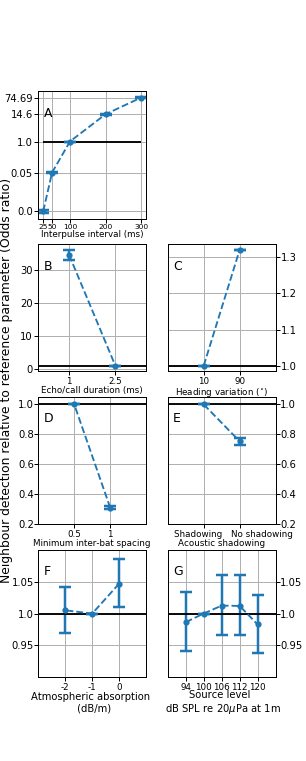

Text(0.0001,0.5,'Neighbour detection relative to reference parameter (Odds ratio)')

In [105]:
relative_x = 0.05
relative_y = 0.8

f = plt.figure(figsize=(3.42,8.5))

# interpulse interval plot 
one = plt.subplot(421)
plt.errorbar( [25, 50, 100, 200, 300],ipi_odds_estimate['oddsratio'],
             yerr=calculate_CI_errorbars(ipi_odds_estimate['oddsratio'],
                                         ipi_odds_estimate['oddsratio_2.5CI'],
                                        ipi_odds_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)

plt.yscale('log')
plt.hlines(1,25,300);plt.grid()
plt.xticks([25, 50, 100, 200, 300],[25, 50, 100, 200, 300], fontsize=6); 
one.tick_params(axis='y', pad=1);one.tick_params(axis='x', pad=1)
plt.xlabel('Interpulse interval (ms)', labelpad=0, fontsize=7)
plt.yticks(ipi_odds_estimate['oddsratio'], 
           np.around(ipi_odds_estimate['oddsratio'],2), fontsize=8)
one.text(relative_x, relative_y, 'A', fontsize=10, transform=one.transAxes)

# call duration plot
two = plt.subplot(423)
plt.errorbar([1,2.5], echocall_estimate['oddsratio'],
                yerr=calculate_CI_errorbars(echocall_estimate['oddsratio'],
                                         echocall_estimate['oddsratio_2.5CI'],
                                        echocall_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3.5)
plt.grid();plt.xticks([2.5,1],[2.5,1],fontsize=7); plt.yticks(fontsize=8)
plt.xlabel('Echo/call duration (ms)', labelpad=0, fontsize=7)
two.text(relative_x, relative_y, 'B', fontsize=10, transform=two.transAxes)
plt.xlim(0,3.5)
two.tick_params(axis='y', pad=1);two.tick_params(axis='x', pad=1)


# heading variation
three = plt.subplot(424)
plt.errorbar([1, 2], headingvarn_estimate['oddsratio'], 
                     yerr=calculate_CI_errorbars(headingvarn_estimate['oddsratio'],
                                         headingvarn_estimate['oddsratio_2.5CI'],
                                        headingvarn_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3)
plt.xlabel('Heading variation ($^{\circ}$)', labelpad=0, fontsize=7)
three.text(relative_x, relative_y, 'C', fontsize=10, transform=three.transAxes)
three.yaxis.tick_right()
plt.grid();plt.xticks([1,2],[10,90],fontsize=7); plt.yticks(fontsize=8)
plt.xlim(0,3)
three.tick_params(axis='y', pad=1);three.tick_params(axis='x', pad=1)

# minimum spacing plot 
four = plt.subplot(425)
plt.errorbar([2,1], minspacing_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(minspacing_estimate['oddsratio'],
                                         minspacing_estimate['oddsratio_2.5CI'],
                                        minspacing_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3.0)
plt.grid()
plt.yticks(fontsize=8)
plt.xticks([1,2],[0.5,1],fontsize=7);
plt.xlim(0,3)
plt.xlabel('Minimum inter-bat spacing', labelpad=0, fontsize=7)
four.text(relative_x, relative_y, 'D', fontsize=10, transform=four.transAxes)
four.tick_params(axis='y', pad=0);four.tick_params(axis='x', pad=1)
plt.ylim(0.2,1.05)


# shadowing plot
five = plt.subplot(426)
plt.errorbar([0,1],shadowing_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(shadowing_estimate['oddsratio'],
                                         shadowing_estimate['oddsratio_2.5CI'],
                                        shadowing_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.grid()
plt.xticks([0,1],['Shadowing    ',
                  '                No shadowing'],fontsize=7); 
plt.yticks(fontsize=8)
plt.xlabel('Acoustic shadowing', labelpad=0, fontsize=7)
five.text(relative_x, relative_y, 'E', fontsize=10, transform=five.transAxes)
five.tick_params(axis='y', pad=0);five.tick_params(axis='x', pad=1)
five.yaxis.tick_right()
plt.yticks(fontsize=8)
plt.hlines(1,-1,2)
plt.xlim(-1,2)
plt.ylim(0.2,1.05)

# atmospheric absorption
six = plt.subplot(427)
plt.errorbar([0,-1,-2],atmosabs_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(atmosabs_estimate['oddsratio'],
                                         atmosabs_estimate['oddsratio_2.5CI'],
                                        atmosabs_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.ylim(0.95, 1.05); plt.grid()
plt.xticks([0,-1,-2],[0,-1,-2], fontsize=7);
plt.hlines(1,-3,1); plt.yticks(fontsize=8)
plt.xlabel('Atmospheric absorption \n (dB/m)', labelpad=0, fontsize=8)
six.text(relative_x, relative_y, 'F', fontsize=10, transform=six.transAxes)
six.tick_params(axis='y', pad=0);six.tick_params(axis='x', pad=1)
plt.yticks([0.95,1.0,1.05],[0.95,1.0,1.05], fontsize=8); plt.ylim(0.90,1.1)
plt.xlim(-3,1)




# source level plot
seven = plt.subplot(428)
plt.errorbar([1,2,3,4,5], sourcelevel_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(sourcelevel_estimate['oddsratio'],
                                         sourcelevel_estimate['oddsratio_2.5CI'],
                                        sourcelevel_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,94,120)
plt.grid()
plt.xticks([1,2,3,4,5],[94, 100, 106, 112, 120],fontsize=7); plt.yticks(fontsize=8)
plt.xlabel('Source level \n dB SPL re 20$\mu$Pa at 1m', labelpad=0, fontsize=8)
seven.text(relative_x, relative_y, 'G', fontsize=10, transform=seven.transAxes)
seven.tick_params(axis='y', pad=0);seven.tick_params(axis='x', pad=1)
plt.yticks([0.95,1.0,1.05],[0.95,1.0,1.05], fontsize=8); plt.ylim(0.90,1.1)
plt.xlim(0,6)
plt.hlines(1,0,6)
seven.yaxis.tick_right()



f.text(0.0001, 0.5, 'Neighbour detection relative to reference parameter (Odds ratio)',
       va='center', rotation='vertical', fontsize=10)
#plt.savefig('Parameterspace_fig_4x2.png', dpi=600)


<IPython.core.display.Javascript object>


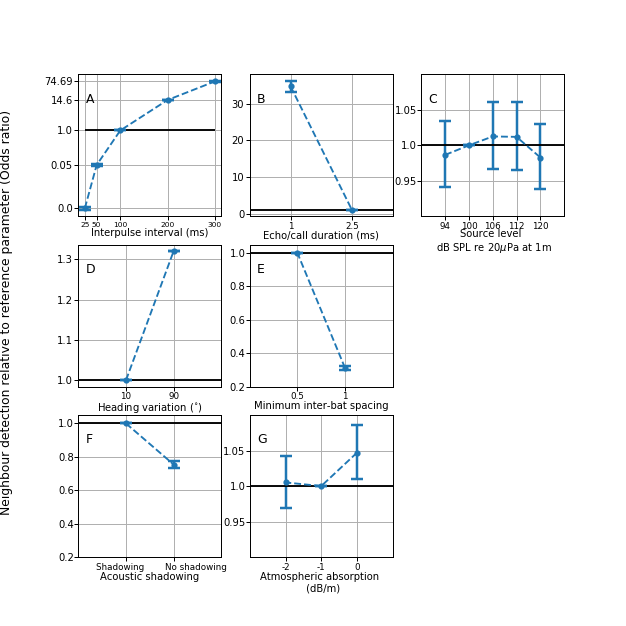

Text(0.0001,0.5,'Neighbour detection relative to reference parameter (Odds ratio)')

In [106]:
## Now trying all the plots in a 3x3 grid
relative_x = 0.05
relative_y = 0.8

f1 = plt.figure(figsize=(7,7))

# interpulse interval plot 
one = plt.subplot(331)
plt.errorbar( [25, 50, 100, 200, 300],ipi_odds_estimate['oddsratio'],
             yerr=calculate_CI_errorbars(ipi_odds_estimate['oddsratio'],
                                         ipi_odds_estimate['oddsratio_2.5CI'],
                                        ipi_odds_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)

plt.yscale('log')
plt.hlines(1,25,300);plt.grid()
plt.xticks([25, 50, 100, 200, 300],[25, 50, 100, 200, 300], fontsize=6); 
one.tick_params(axis='y', pad=1);one.tick_params(axis='x', pad=1)
plt.xlabel('Interpulse interval (ms)', labelpad=0, fontsize=8)
plt.yticks(ipi_odds_estimate['oddsratio'], np.around(ipi_odds_estimate['oddsratio'],2), fontsize=8)
one.text(relative_x, relative_y, 'A', fontsize=10, transform=one.transAxes)

# call duration plot
two = plt.subplot(332)
plt.errorbar([1,2.5], echocall_estimate['oddsratio'],
                yerr=calculate_CI_errorbars(echocall_estimate['oddsratio'],
                                         echocall_estimate['oddsratio_2.5CI'],
                                        echocall_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3.5)
plt.grid();plt.xticks([2.5,1],[2.5,1],fontsize=7); plt.yticks(fontsize=8)
plt.xlabel('Echo/call duration (ms)', labelpad=0, fontsize=8)
two.text(relative_x, relative_y, 'B', fontsize=10, transform=two.transAxes)
plt.xlim(0,3.5)
two.tick_params(axis='y', pad=1);two.tick_params(axis='x', pad=1)





# source level plot
seven = plt.subplot(333)
plt.errorbar([1,2,3,4,5], sourcelevel_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(sourcelevel_estimate['oddsratio'],
                                         sourcelevel_estimate['oddsratio_2.5CI'],
                                        sourcelevel_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,94,120)
plt.grid()
plt.xticks([1,2,3,4,5],[94, 100, 106, 112, 120],fontsize=7); plt.yticks(fontsize=8)
plt.xlabel('Source level \n dB SPL re 20$\mu$Pa at 1m', labelpad=0, fontsize=8)
seven.text(relative_x, relative_y, 'C', fontsize=10, transform=seven.transAxes)
seven.tick_params(axis='y', pad=0);seven.tick_params(axis='x', pad=1)
plt.yticks([0.95,1.0,1.05],[0.95,1.0,1.05], fontsize=8); plt.ylim(0.90,1.1)
plt.xlim(0,6)
plt.hlines(1,0,6)








# heading variation
three = plt.subplot(334)
plt.errorbar([1, 2], headingvarn_estimate['oddsratio'], 
                     yerr=calculate_CI_errorbars(headingvarn_estimate['oddsratio'],
                                         headingvarn_estimate['oddsratio_2.5CI'],
                                        headingvarn_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3)
plt.xlabel('Heading variation ($^{\circ}$)', labelpad=0, fontsize=8)
three.text(relative_x, relative_y, 'D', fontsize=10, transform=three.transAxes)
plt.grid();plt.xticks([1,2],[10,90],fontsize=7); plt.yticks(fontsize=8)
plt.xlim(0,3)
three.tick_params(axis='y', pad=1);three.tick_params(axis='x', pad=1)

# minimum spacing plot 
four = plt.subplot(335)
plt.errorbar([2,1], minspacing_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(minspacing_estimate['oddsratio'],
                                         minspacing_estimate['oddsratio_2.5CI'],
                                        minspacing_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3.0)
plt.grid()
plt.yticks(fontsize=8)
plt.xticks([1,2],[0.5,1],fontsize=7);
plt.xlim(0,3)
plt.xlabel('Minimum inter-bat spacing', labelpad=0, fontsize=8)
four.text(relative_x, relative_y, 'E', fontsize=10, transform=four.transAxes)
four.tick_params(axis='y', pad=0);four.tick_params(axis='x', pad=1)
plt.ylim(0.2,1.05)


# shadowing plot
five = plt.subplot(337)
plt.errorbar([0,1],shadowing_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(shadowing_estimate['oddsratio'],
                                         shadowing_estimate['oddsratio_2.5CI'],
                                        shadowing_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.grid()
plt.xticks([0,1],['Shadowing    ',
                  '                No shadowing'],fontsize=7); 
plt.yticks(fontsize=8)
plt.xlabel('Acoustic shadowing', labelpad=0, fontsize=8)
five.text(relative_x, relative_y, 'F', fontsize=10, transform=five.transAxes)
five.tick_params(axis='y', pad=0);five.tick_params(axis='x', pad=1)
plt.yticks(fontsize=8)
plt.hlines(1,-1,2)
plt.xlim(-1,2)
plt.ylim(0.2,1.05)

# atmospheric absorption
six = plt.subplot(338)
plt.errorbar([0,-1,-2],atmosabs_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(atmosabs_estimate['oddsratio'],
                                         atmosabs_estimate['oddsratio_2.5CI'],
                                        atmosabs_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.ylim(0.95, 1.05); plt.grid()
plt.xticks([0,-1,-2],[0,-1,-2], fontsize=7);
plt.hlines(1,-3,1); plt.yticks(fontsize=8)
plt.xlabel('Atmospheric absorption \n (dB/m)', labelpad=0, fontsize=8)
six.text(relative_x, relative_y, 'G', fontsize=10, transform=six.transAxes)
six.tick_params(axis='y', pad=0);six.tick_params(axis='x', pad=1)
plt.yticks([0.95,1.0,1.05],[0.95,1.0,1.05], fontsize=8); plt.ylim(0.90,1.1)
plt.xlim(-3,1)







f1.text(0.0001, 0.5, 'Neighbour detection relative to reference parameter (Odds ratio)',
       va='center', rotation='vertical', fontsize=10)
#plt.savefig('Parameterspace_fig_3x3.png', dpi=600)


<IPython.core.display.Javascript object>


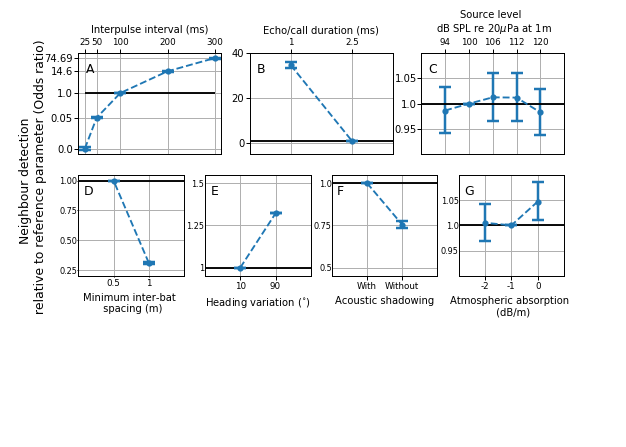

In [107]:
## Now trying all the plots in a 3x3 grid -- BUT WITH INEQUAL SUBPLOT SIZES!
# Thanks to Quinn Dizon, 
# https://towardsdatascience.com/subplots-in-matplotlib-a-guide-and-tool-for-planning-your-plots-7d63fa632857
relative_x = 0.05
relative_y = 0.8

f1 = plt.figure(figsize=(7,5))

# interpulse interval plot 
one = f1.add_subplot(331)
plt.errorbar( [25, 50, 100, 200, 300],ipi_odds_estimate['oddsratio'],
             yerr=calculate_CI_errorbars(ipi_odds_estimate['oddsratio'],
                                         ipi_odds_estimate['oddsratio_2.5CI'],
                                        ipi_odds_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.yscale('log')
plt.hlines(1,25,300);plt.grid()
plt.xticks([25, 50, 100, 200, 300],[25, 50, 100, 200, 300], fontsize=7); 
one.tick_params(axis='y', pad=1);one.tick_params(axis='x', pad=1)
plt.xlabel('Interpulse interval (ms)', labelpad=4, fontsize=8)
one.xaxis.set_label_position('top') 
one.xaxis.tick_top()
plt.yticks(ipi_odds_estimate['oddsratio'], np.around(ipi_odds_estimate['oddsratio'],2),
           fontsize=8)
one.text(relative_x, relative_y, 'A', fontsize=10, transform=one.transAxes)

# call duration plot
two = f1.add_subplot(332)
plt.errorbar([1,2.5], echocall_estimate['oddsratio'],
                yerr=calculate_CI_errorbars(echocall_estimate['oddsratio'],
                                         echocall_estimate['oddsratio_2.5CI'],
                                        echocall_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3.5)
plt.grid();plt.xticks([2.5,1],[2.5,1], fontsize=7); plt.yticks(fontsize=8)
plt.xlabel('Echo/call duration (ms)', labelpad=4, fontsize=8)
two.text(relative_x, relative_y, 'B', fontsize=10, transform=two.transAxes)
plt.xlim(0,3.5)
plt.ylim(-5,40)
two.tick_params(axis='y', pad=1);two.tick_params(axis='x', pad=1)
two.xaxis.set_label_position('top') 
two.xaxis.tick_top()





# source level plot
three = f1.add_subplot(333)
plt.errorbar([1,2,3,4,5], sourcelevel_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(sourcelevel_estimate['oddsratio'],
                                         sourcelevel_estimate['oddsratio_2.5CI'],
                                        sourcelevel_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,94,120)
plt.grid()
plt.xticks([1,2,3,4,5],[94, 100, 106, 112, 120],fontsize=7); plt.yticks(fontsize=8)
plt.xlabel('Source level \n dB SPL re 20$\mu$Pa at 1m', labelpad=4, fontsize=8)
three.text(relative_x, relative_y, 'C', fontsize=10, transform=three.transAxes)
three.tick_params(axis='y', pad=0);three.tick_params(axis='x', pad=1)
plt.yticks([0.95,1.0,1.05],[0.95,1.0,1.05], fontsize=8); plt.ylim(0.90,1.1)
plt.xlim(0,6)
plt.hlines(1,0,6)
three.xaxis.set_label_position('top') 
three.xaxis.tick_top()


# minimum spacing plot 
five = plt.subplot(345)
plt.errorbar([2,1], minspacing_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(minspacing_estimate['oddsratio'],
                                         minspacing_estimate['oddsratio_2.5CI'],
                                        minspacing_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3.0)
plt.grid()
plt.yticks(fontsize=6.5)
plt.xticks([1,2],[0.5,1],fontsize=7);
plt.xlim(0,3)
plt.xlabel('Minimum inter-bat \n spacing (m)', labelpad=4, fontsize=8)
five.text(relative_x, relative_y, 'D', fontsize=10, transform=five.transAxes)
five.tick_params(axis='y', pad=0);five.tick_params(axis='x', pad=1)
plt.ylim(0.2,1.05)
five.tick_params(length=1)


# heading variation
four = f1.add_subplot(346)
plt.errorbar([1, 2], headingvarn_estimate['oddsratio'], 
                     yerr=calculate_CI_errorbars(headingvarn_estimate['oddsratio'],
                                         headingvarn_estimate['oddsratio_2.5CI'],
                                        headingvarn_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.hlines(1,0,3)
plt.xlabel('Heading variation ($^{\circ}$)', labelpad=4, fontsize=8)
four.text(relative_x, relative_y, 'E', fontsize=10, transform=four.transAxes)
plt.grid();plt.xticks([1,2],[10,90],fontsize=7); 
plt.yticks([1,1.25, 1.5],[1,1.25, 1.5],fontsize=6.5)
plt.xlim(0,3)
plt.ylim(0.95,1.55)
four.tick_params(axis='y', pad=1, length=0);four.tick_params(axis='x', pad=1)



# shadowing plot
six = plt.subplot(347)
plt.errorbar([0,1],shadowing_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(shadowing_estimate['oddsratio'],
                                         shadowing_estimate['oddsratio_2.5CI'],
                                        shadowing_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.grid()
plt.xticks([0,1],['With', 'Without'],fontsize=7); 
plt.xlabel('Acoustic shadowing', labelpad=4, fontsize=8)
six.text(relative_x, relative_y, 'F', fontsize=10, transform=six.transAxes)
six.tick_params(axis='y', pad=0, length=0);six.tick_params(axis='x', pad=1)
plt.yticks([0.5,0.75,1.0],[0.5,0.75,1.0],fontsize=6.5)
plt.hlines(1,-1,2)
plt.xlim(-1,2)
plt.ylim(0.45,1.05)

# atmospheric absorption
seven = plt.subplot(348)
plt.errorbar([0,-1,-2],atmosabs_estimate['oddsratio'],
         yerr=calculate_CI_errorbars(atmosabs_estimate['oddsratio'],
                                         atmosabs_estimate['oddsratio_2.5CI'],
                                        atmosabs_estimate['oddsratio_97.5CI']), 
                                         fmt='--.',
                                         capsize=5, 
                                        elinewidth=2,
                                        markeredgewidth=2)
plt.ylim(0.95, 1.05); plt.grid()
plt.xticks([0,-1,-2],[0,-1,-2], fontsize=7);
plt.hlines(1,-3,1); plt.yticks(fontsize=8)
plt.xlabel('Atmospheric absorption \n (dB/m)', labelpad=4, fontsize=8)
seven.text(relative_x, relative_y, 'G', fontsize=10, transform=seven.transAxes)
seven.tick_params(axis='y', pad=0, length=0);seven.tick_params(axis='x', pad=1)
plt.yticks([0.95,1.0,1.05],[0.95,1.0,1.05], fontsize=6.5); plt.ylim(0.90,1.1)
plt.xlim(-3,1)


f1.text(0.03, 0.6, 'Neighbour detection \n relative to reference parameter (Odds ratio)',
       va='center', rotation='vertical', fontsize=10,multialignment='center')
#plt.savefig('Parameterspace_fig_3x3.png', dpi=600)
plt.savefig('Parameterspace_fig_3xN.pdf',
    bbox_inches='tight', pad_inches=0, format='pdf', dpi=1200)

# Regression Analyses that did not explain the data as well - but nonetheless showed similar trends :
To be transparent - I present here the other regression models that I tried to fit the data to - but which were not as succesful in their predictions. 

In [108]:
regression_rundata.columns 

Index([u'echo_directions', u'echo_levels', u'group_diameter', u'group_size',
       u'nbrs_detected', u'nbrs_detected_distance',
       u'nearest_neighbour_distance', u'parameters_joint', u'paramset_id',
       u'seed', u'uuid', u'heading_variation', u'echocall_duration',
       u'atmospheric_attenuation', u'min_spacing', u'source_level',
       u'interpulse_interval', u'implement_shadowing', u'geq_oneneighbour'],
      dtype='object')

In [109]:
formula = 'nbrs_detected~heading_variation+ \
        implement_shadowing+interpulse_interval+\
        min_spacing+echocall_duration + source_level + atmospheric_attenuation'

In [110]:
model_num_echoes = smf.glm(formula, data=regression_rundata, 
                           family = sm.families.NegativeBinomial(sm.families.links.log))

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  from ipykernel import kernelapp as app


In [111]:
negbinom_fit = model_num_echoes.fit()

In [112]:
negbinom_fit.aic

621148.3705134622

In [113]:
model_num_echoes.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          nbrs_detected   No. Observations:               240566
Model:                            GLM   Df Residuals:                   240551
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1056e+05
Date:                Fri, 18 Oct 2019   Deviance:                       78838.
Time:                        07:49:27   Pearson chi2:                 1.00e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.8139      0.013    -64.513      0.000      -0.839      -0.789
heading_variation[T.90]           0.0309      0.006      4.855      0.000       0.018       0.043
implement_shadowing[T.False]     -0.0908      0.006    -14.243      0.000      -0.103      -0.078
interpulse_interval[T.0.05]      -1.8334      0.015   -122.774      0.000      -1.863      -1.804
interpulse_interval[T.0.025]     -5.3725      0.071    -75.852      0.000      -5.511      -5.234
interpulse_interval[T.0.2]        1.3065      0.009    146.343      0.000       1.289       1.324
interpulse_interval[T.0.3]        1.9601      0.009    224.270      0.000       1.943       1.977
min_spacing[T.1.0]               -0.5077      0.006    -79.252      0.000      -0.520      -0.495
echocall_duration[T.0.001]        1.4501      0.007    219.066      0.000       1.437       1.463
source_level[T.94]               -0.0034      0.010     -0.334      0.738      -0.023       0.016
source_level[T.106]               0.0008      0.010      0.077      0.939      -0.019       0.021
source_level[T.112]               0.0011      0.010      0.111      0.911      -0.019       0.021
source_level[T.120]              -0.0031      0.010     -0.307      0.759      -0.023       0.017
atmospheric_attenuation[T.0]      0.0049      0.008      0.624      0.533      -0.010       0.020
atmospheric_attenuation[T.-2]     0.0036      0.008      0.465      0.642      -0.012       0.019
=================================================================================================
"""

In [114]:
predictions = model_num_echoes.fit().predict()
observed = np.array(regression_rundata['nbrs_detected'])
residue = observed - predictions

<IPython.core.display.Javascript object>


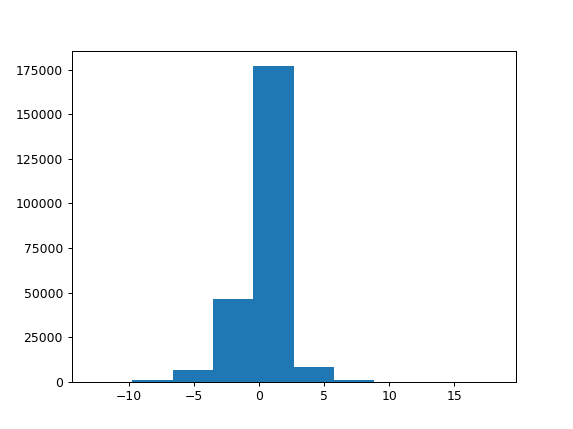

In [115]:
plt.figure()
plt.hist(residue);

In [116]:
prediction_error, occurence = np.unique(residue, return_counts=True)
occurence = np.float64(occurence)
occurence /= np.sum(occurence)

<IPython.core.display.Javascript object>


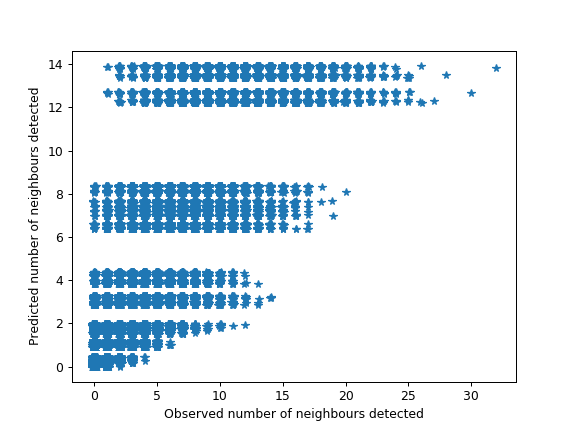

Text(0,0.5,'Predicted number of neighbours detected')

In [117]:
plt.figure()
plt.plot(observed+np.random.normal(0,0.05,observed.size),
         predictions, '*')
plt.xlabel('Observed number of neighbours detected')
plt.ylabel('Predicted number of neighbours detected')

In [118]:
negbinom_confusion_matrix = metrics.confusion_matrix(observed, np.around(predictions))

In [119]:
negbinom_rates = calc_rate_per_column(negbinom_confusion_matrix)

<IPython.core.display.Javascript object>


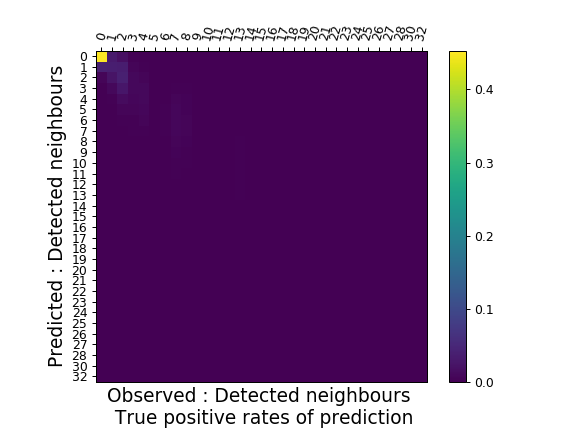

Text(0,0.5,'Predicted : Detected neighbours')

In [120]:
fig, ax = plt.subplots()
heatmap = ax.imshow(negbinom_rates)
fig.colorbar(heatmap)
ax.set_xticks(np.arange(negbinom_rates.shape[0]))
ax.set_xticklabels(np.unique(observed), rotation=75);
ax.xaxis.tick_top()
ax.set_yticks(np.arange(negbinom_rates.shape[0]))
ax.set_yticklabels(np.unique(observed));
plt.xlabel('Observed : Detected neighbours \n True positive rates of prediction', fontsize=15)
plt.ylabel('Predicted : Detected neighbours', fontsize=15)

### We can see that the predictions are correct highest at predicting when 0 neighbours are detected - and that too only 50% of the time. The negative binomial model isn't doing a very great job at predicting the number of neighbours detected. 

<IPython.core.display.Javascript object>


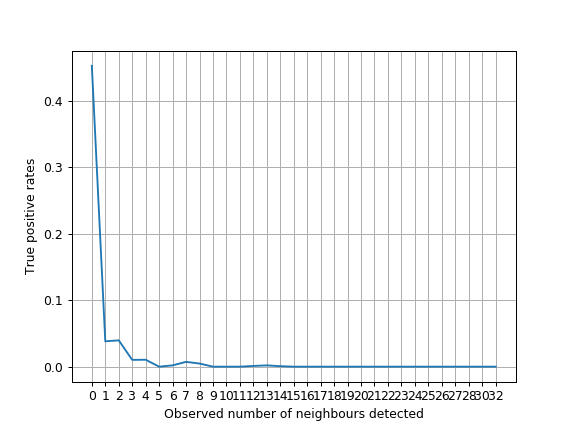

In [121]:
plt.figure()
plt.plot(np.diag(negbinom_rates));plt.ylabel('True positive rates')
plt.xticks(range(np.unique(observed).size), np.unique(observed))
plt.xlabel('Observed number of neighbours detected');plt.grid()

### Perhaps zero-inflation is affecting the efficacy of prediction?
#### Many of the simulations actually show that a bat has detected zero neighbours - and unless accounted for specifically many regression models are not formulated with zero-inflated data. 

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


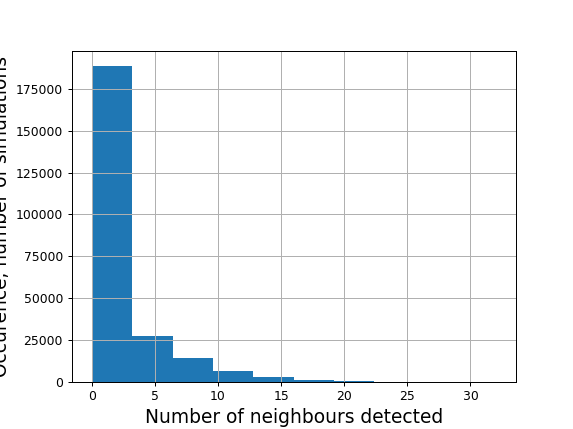

Text(0,0.5,'Occurence, number of simulations')

In [122]:
plt.figure()
plt.hist(observed);
plt.grid()
plt.xlabel('Number of neighbours detected', fontsize=15)
plt.ylabel('Occurence, number of simulations', fontsize=15)

### The histogram shows a preponderance of zeroes in the dataset. Let us use zero-inflated Poisson models to handle the dataset.

In [123]:
# folllowing https://bryansweber.com/2018/10/26/python-and-zero-inflated-models/ accessed 14-09-2019
import statsmodels.discrete.count_model as reg_models

In [124]:
modelw_zip = reg_models.ZeroInflatedPoisson.from_formula(formula, regression_rundata)

In [125]:
zipmodel_fit = modelw_zip.fit()

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 1.116744
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [126]:
zipmodel_predict = zipmodel_fit.predict()

In [127]:
zipmodel_residues = observed - zipmodel_predict

<IPython.core.display.Javascript object>


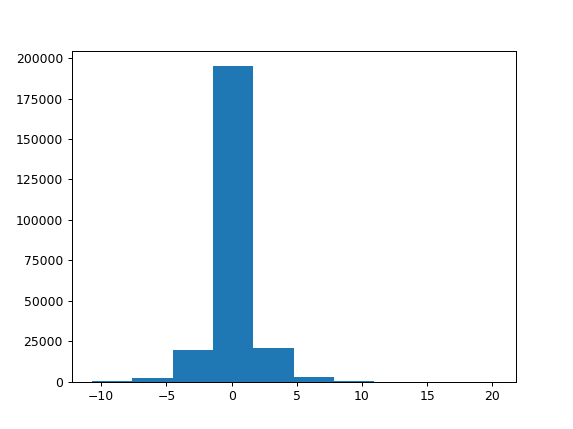

In [128]:
plt.figure()
plt.hist(zipmodel_residues);

<IPython.core.display.Javascript object>


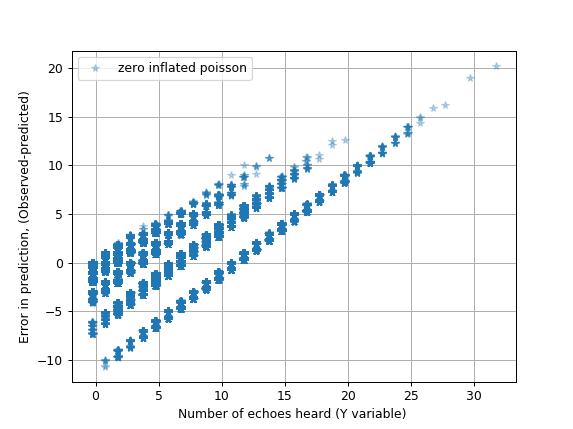

In [129]:
plt.figure()
plt.plot(observed-0.25+np.random.normal(0,0.01,observed.size),
         zipmodel_residues, '*', alpha=0.3,
         label='zero inflated poisson')

plt.xlabel('Number of echoes heard (Y variable) ')
plt.ylabel('Error in prediction, (Observed-predicted)')
plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


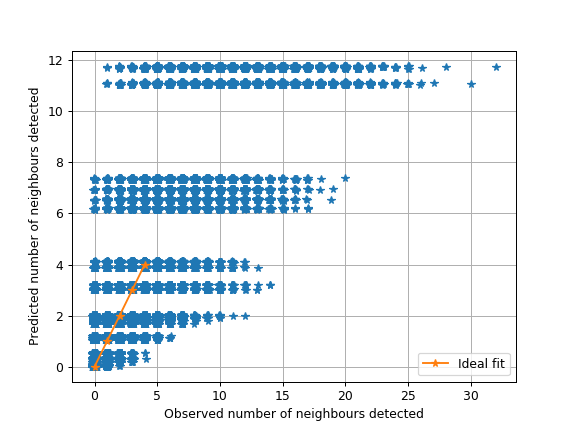

In [130]:
plt.figure()
plt.plot(observed+np.random.normal(0,0.05,observed.size),
         zipmodel_predict, '*')
plt.plot(np.arange(5),np.arange(5),'-*',label='Ideal fit')
plt.xlabel('Observed number of neighbours detected')
plt.ylabel('Predicted number of neighbours detected')
plt.legend();plt.grid()

In [131]:
# calculate the confusion matrix for the zero inflated Poisson 
zip_confusion_matrix = metrics.confusion_matrix(observed, np.around(zipmodel_predict))
zip_prediction_rates = calc_rate_per_column(zip_confusion_matrix)

<IPython.core.display.Javascript object>


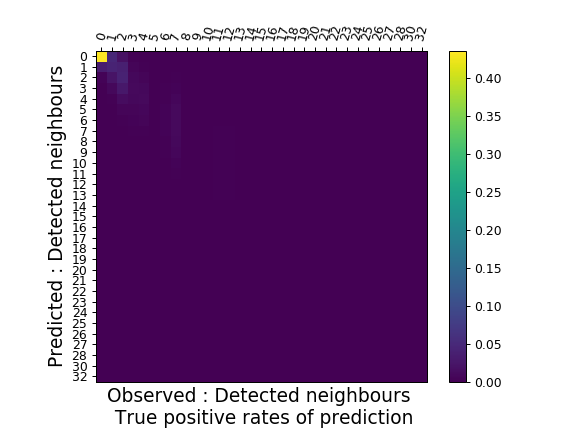

Text(0,0.5,'Predicted : Detected neighbours')

In [132]:
# rate of true positives in the predictions
fig, ax = plt.subplots()
heatmap = ax.imshow(zip_prediction_rates)
fig.colorbar(heatmap)
ax.set_xticks(np.arange(zip_prediction_rates.shape[0]))
ax.set_xticklabels(np.unique(observed), rotation=75);
ax.xaxis.tick_top()
ax.set_yticks(np.arange(zip_prediction_rates.shape[0]))
ax.set_yticklabels(np.unique(observed));
plt.xlabel('Observed : Detected neighbours \n True positive rates of prediction', fontsize=15)
plt.ylabel('Predicted : Detected neighbours', fontsize=15)

### Even the zero-inflated Poisson model doesn't predict the observed data too well. At its best the cases of zero neighbours detected are predicted, but that too only about 50%  of the time. 

## The negative binomial and zero-inflated Poisson models:


In [133]:
zipmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:           nbrs_detected   No. Observations:               240566
Model:             ZeroInflatedPoisson   Df Residuals:                   240551
Method:                            MLE   Df Model:                           14
Date:                 Fri, 18 Oct 2019   Pseudo R-squ.:                  0.4601
Time:                         07:49:46   Log-Likelihood:            -2.6865e+05
converged:                       False   LL-Null:                   -4.9756e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
inflate_const                    -7.1659      0.197    -36.348      0.000      -7.552      -6.780
Intercept                        -0.6419      0.007    -94.420      0.000      -0.655      -0.629
heading_variation[T.90]          -0.0013      0.003     -0.454      0.650      -0.007       0.004
implement_shadowing[T.False]     -0.0567      0.003    -19.954      0.000      -0.062      -0.051
interpulse_interval[T.0.05]      -1.8629      0.013   -147.249      0.000      -1.888      -1.838
interpulse_interval[T.0.025]     -5.5603      0.075    -74.239      0.000      -5.707      -5.413
interpulse_interval[T.0.2]        1.2228      0.005    232.015      0.000       1.213       1.233
interpulse_interval[T.0.3]        1.8058      0.005    360.811      0.000       1.796       1.816
min_spacing[T.1.0]               -0.4680      0.003   -160.276      0.000      -0.474      -0.462
echocall_duration[T.0.001]        1.2994      0.003    375.923      0.000       1.293       1.306
source_level[T.94]               -0.0014      0.004     -0.301      0.764      -0.010       0.007
source_level[T.106]              -0.0042      0.004     -0.927      0.354      -0.013       0.005
source_level[T.112]              -0.0015      0.004     -0.323      0.747      -0.010       0.007
source_level[T.120]              -0.0057      0.004     -1.266      0.206      -0.014       0.003
atmospheric_attenuation[T.0]      0.0015      0.003      0.420      0.675      -0.005       0.008
atmospheric_attenuation[T.-2]     0.0040      0.003      1.166      0.244      -0.003       0.011
=================================================================================================
"""

In [134]:
negbinom_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          nbrs_detected   No. Observations:               240566
Model:                            GLM   Df Residuals:                   240551
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1056e+05
Date:                Fri, 18 Oct 2019   Deviance:                       78838.
Time:                        07:49:46   Pearson chi2:                 1.00e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.8139      0.013    -64.513      0.000      -0.839      -0.789
heading_variation[T.90]           0.0309      0.006      4.855      0.000       0.018       0.043
implement_shadowing[T.False]     -0.0908      0.006    -14.243      0.000      -0.103      -0.078
interpulse_interval[T.0.05]      -1.8334      0.015   -122.774      0.000      -1.863      -1.804
interpulse_interval[T.0.025]     -5.3725      0.071    -75.852      0.000      -5.511      -5.234
interpulse_interval[T.0.2]        1.3065      0.009    146.343      0.000       1.289       1.324
interpulse_interval[T.0.3]        1.9601      0.009    224.270      0.000       1.943       1.977
min_spacing[T.1.0]               -0.5077      0.006    -79.252      0.000      -0.520      -0.495
echocall_duration[T.0.001]        1.4501      0.007    219.066      0.000       1.437       1.463
source_level[T.94]               -0.0034      0.010     -0.334      0.738      -0.023       0.016
source_level[T.106]               0.0008      0.010      0.077      0.939      -0.019       0.021
source_level[T.112]               0.0011      0.010      0.111      0.911      -0.019       0.021
source_level[T.120]              -0.0031      0.010     -0.307      0.759      -0.023       0.017
atmospheric_attenuation[T.0]      0.0049      0.008      0.624      0.533      -0.010       0.020
atmospheric_attenuation[T.-2]     0.0036      0.008      0.465      0.642      -0.012       0.019
=================================================================================================
"""

### Both count models show the same trends as the logistic regression.